In [10]:
#Calulate and S ave the tree cover percentage of india from 2000 to 2020 using MODIS dataset
import ee

# Initialize the Earth Engine API
ee.Initialize()

# Define the AOI for India
india_geometry = ee.Geometry.Polygon([
    [[68.1767, 7.9655], [68.1767, 35.5087], [97.4026, 35.5087], [97.4026, 7.9655], [68.1767, 7.9655]]
])

# Load the MODIS Tree Cover dataset
modis_tree_cover = ee.ImageCollection("MODIS/006/MOD44B")

# Function to calculate annual tree cover percentage for a region
def calculate_tree_cover_percentage(region):
    # List of years available in the dataset
    years = ee.List(modis_tree_cover.aggregate_array('system:time_start').map(
        lambda time: ee.Date(time).get('year')
    )).distinct().sort().getInfo()

    # Initialize an array to store results
    annual_tree_cover = []

    for year in years:
        # Filter the collection for the specific year
        yearly_collection = modis_tree_cover.filter(ee.Filter.calendarRange(year, year, 'year'))
        if yearly_collection.size().getInfo() == 0:
            continue  # Skip if no data for the year

        # Get the mean tree cover percentage for the year
        mean_tree_cover = yearly_collection.mean().select('Percent_Tree_Cover').reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=region,
            scale=500,  # Use the dataset's native resolution
            maxPixels=1e9
        ).get('Percent_Tree_Cover')

        # Retrieve the value (or handle missing data)
        mean_tree_cover_value = ee.Number(mean_tree_cover).getInfo() if mean_tree_cover else None
        annual_tree_cover.append({'year': year, 'tree_cover_percentage': mean_tree_cover_value})

    return annual_tree_cover

# Calculate tree cover percentage for India
india_tree_cover = calculate_tree_cover_percentage(india_geometry)

# Display the results
for entry in india_tree_cover:
    print(f"Year: {entry['year']}, Tree Cover Percentage: {entry['tree_cover_percentage']:.2f}")


Year: 2000, Tree Cover Percentage: 10.94
Year: 2001, Tree Cover Percentage: 10.62
Year: 2002, Tree Cover Percentage: 11.38
Year: 2003, Tree Cover Percentage: 10.76
Year: 2004, Tree Cover Percentage: 11.38
Year: 2005, Tree Cover Percentage: 11.74
Year: 2006, Tree Cover Percentage: 11.98
Year: 2007, Tree Cover Percentage: 11.29
Year: 2008, Tree Cover Percentage: 11.00
Year: 2009, Tree Cover Percentage: 11.28
Year: 2010, Tree Cover Percentage: 10.91
Year: 2011, Tree Cover Percentage: 10.85
Year: 2012, Tree Cover Percentage: 10.79
Year: 2013, Tree Cover Percentage: 11.88
Year: 2014, Tree Cover Percentage: 12.25
Year: 2015, Tree Cover Percentage: 12.53
Year: 2016, Tree Cover Percentage: 11.25
Year: 2017, Tree Cover Percentage: 11.81
Year: 2018, Tree Cover Percentage: 11.73
Year: 2019, Tree Cover Percentage: 12.70
Year: 2020, Tree Cover Percentage: 13.61


Error calculating for 2021: Dictionary.get: Dictionary does not contain key: 'Percent_Tree_Cover'.


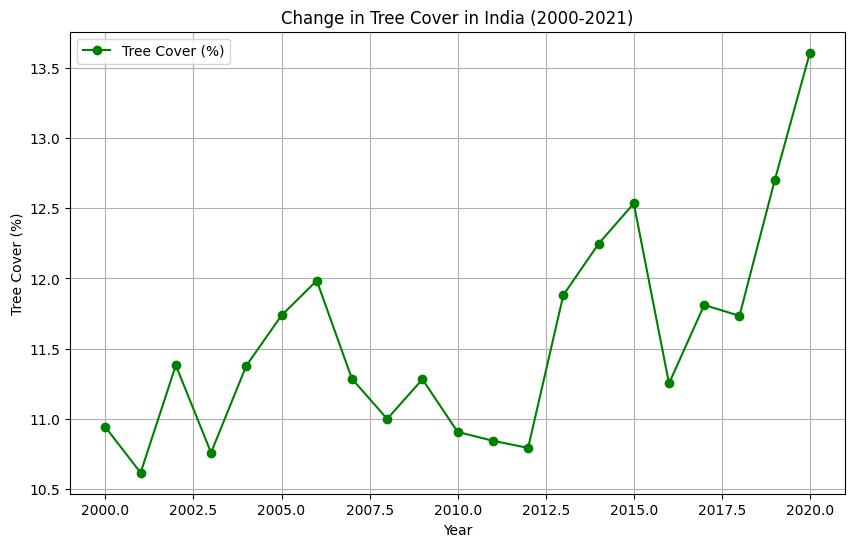

In [11]:
#Plots the tree cover percentage of india from 2000 to 2020 using MODIS dataset
import ee
import matplotlib.pyplot as plt

# Initialize the Earth Engine API
ee.Initialize()

# Load the MODIS Vegetation Continuous Fields dataset
tree_cover_dataset = ee.ImageCollection("MODIS/006/MOD44B")

# Define the region of interest (India)
india_geometry = ee.Geometry.Polygon([
    [[68.1767, 7.9655], [68.1767, 35.5087], [97.4026, 35.5087], [97.4026, 7.9655], [68.1767, 7.9655]]
])

# List of years for analysis (MODIS data starts from 2000)
years = list(range(2000, 2022))

# Function to calculate average tree cover per year
def calculate_annual_tree_cover(year):
    # Filter the dataset for the specific year
    year_filter = tree_cover_dataset.filter(ee.Filter.calendarRange(year, year, 'year'))
    
    # Extract the tree cover band and calculate mean
    tree_cover = year_filter.select('Percent_Tree_Cover').mean().clip(india_geometry)
    
    # Calculate the mean tree cover percentage for the region
    mean_tree_cover = tree_cover.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=india_geometry,
        scale=500,
        maxPixels=1e9
    ).get('Percent_Tree_Cover')
    
    return ee.Number(mean_tree_cover).getInfo()

# Loop through years to get tree cover data
tree_cover_data = []
for year in years:
    try:
        mean_tree_cover_percentage = calculate_annual_tree_cover(year)
        tree_cover_data.append((year, mean_tree_cover_percentage))
    except Exception as e:
        print(f"Error calculating for {year}: {e}")
        tree_cover_data.append((year, None))

# Convert to lists for plotting
years_list = [data[0] for data in tree_cover_data]
tree_cover_percentages = [data[1] for data in tree_cover_data]

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(years_list, tree_cover_percentages, marker='o', color='green', label='Tree Cover (%)')
plt.xlabel('Year')
plt.ylabel('Tree Cover (%)')
plt.title('Change in Tree Cover in India (2000-2021)')
plt.grid(True)
plt.legend()
plt.show()

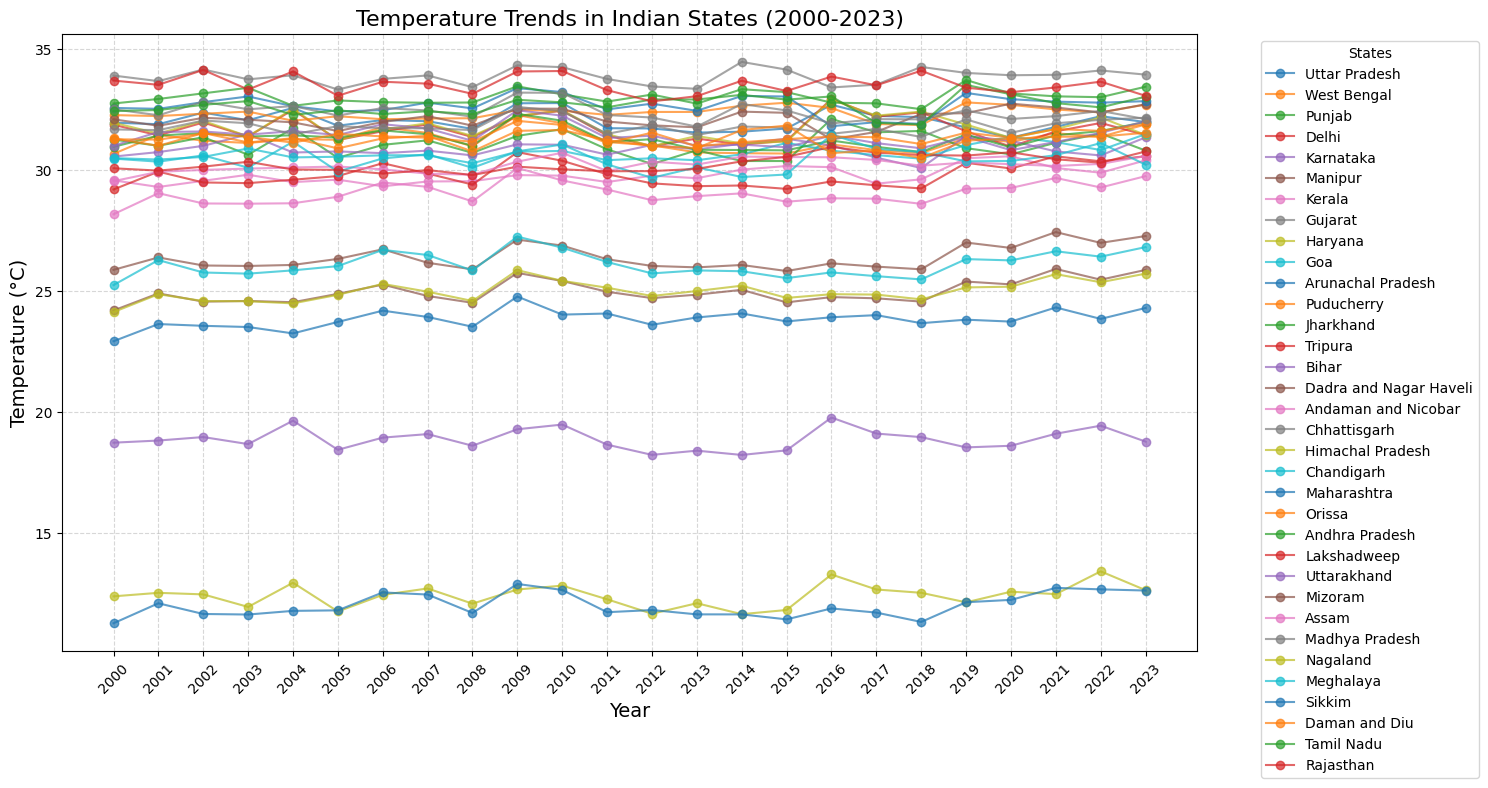

In [15]:
#  Calculate and Save the temperature data of Indian states from 2000 to 2023 using the ERA5 dataset
import matplotlib.pyplot as plt
import numpy as np

# Convert the data into a structure for plotting
states = list(set([entry["State"] for entry in result]))
years = sorted(list(set([entry["Year"] for entry in result])))

# Create a dictionary to map state -> year-wise temperature
state_temp_data = {state: {year: None for year in years} for state in states}

for entry in result:
    state = entry["State"]
    year = entry["Year"]
    temp = entry["Temperature (°C)"]
    state_temp_data[state][year] = temp

# Plotting
plt.figure(figsize=(15, 8))

for state, temp_data in state_temp_data.items():
    # Extract years and temperatures for the state
    x = list(temp_data.keys())
    y = [temp_data[year] for year in x]
    
    # Handle missing data (e.g., None) by interpolating or skipping
    y = np.array(y, dtype=np.float64)
    plt.plot(x, y, label=state, marker='o', alpha=0.7)

# Customizing the graph
plt.title("Temperature Trends in Indian States (2000-2023)", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Temperature (°C)", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(years, rotation=45)
plt.legend(title="States", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()

In [22]:
#Obtainig the tree cover percentage of Assam and Meghalaya from 2000 to 2020 using MODIS dataset
import ee

# Initialize the Earth Engine API
ee.Initialize()

# Define the geometry for Assam and Meghalaya (you could replace this with actual boundary data)
india_states = ee.FeatureCollection("FAO/GAUL/2015/level1")
india_states_filtered = india_states.filter(ee.Filter.Or(
    ee.Filter.eq("ADM1_NAME", "Meghalaya"),
    ee.Filter.eq("ADM1_NAME", "Assam")
))

# Load the MODIS Tree Cover dataset
modis_tree_cover = ee.ImageCollection("MODIS/006/MOD44B")

# Function to calculate annual tree cover percentage for a specific state
def calculate_tree_cover_percentage_for_state(state_feature):
    state_name = state_feature.get("ADM1_NAME")  # Get state name
    state_geometry = state_feature.geometry()

    # List of years available in the dataset
    years = ee.List(modis_tree_cover.aggregate_array('system:time_start').map(
        lambda time: ee.Date(time).get('year')
    )).distinct().sort().getInfo()

    # Initialize an array to store results
    annual_tree_cover = []

    for year in years:
        # Filter the collection for the specific year
        yearly_collection = modis_tree_cover.filter(ee.Filter.calendarRange(year, year, 'year'))
        if yearly_collection.size().getInfo() == 0:
            continue  # Skip if no data for the year

        # Get the mean tree cover percentage for the year
        mean_tree_cover = yearly_collection.mean().select('Percent_Tree_Cover').reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=state_geometry,
            scale=500,  # Use the dataset's native resolution
            maxPixels=1e9
        ).get('Percent_Tree_Cover')

        # Retrieve the value (or handle missing data)
        mean_tree_cover_value = ee.Number(mean_tree_cover).getInfo() if mean_tree_cover else None
        annual_tree_cover.append({'year': year, 'tree_cover_percentage': mean_tree_cover_value})

    return annual_tree_cover

# Apply the function to each state (Assam and Meghalaya)
state_tree_cover_data = []
state_features = india_states_filtered.getInfo()['features']

for state_feature in state_features:
    state_tree_cover = calculate_tree_cover_percentage_for_state(ee.Feature(ee.Geometry(state_feature['geometry'])))
    for entry in state_tree_cover:
        state_tree_cover_data.append({
            "State": state_feature['properties']['ADM1_NAME'],
            "Year": entry['year'],
            "Tree Cover Percentage": entry['tree_cover_percentage']
        })

# Display the results
for data in state_tree_cover_data:
    print(f"State: {data['State']}, Year: {data['Year']}, Tree Cover Percentage: {data['Tree Cover Percentage']:.2f}")


State: Assam, Year: 2000, Tree Cover Percentage: 26.40
State: Assam, Year: 2001, Tree Cover Percentage: 25.78
State: Assam, Year: 2002, Tree Cover Percentage: 27.77
State: Assam, Year: 2003, Tree Cover Percentage: 28.71
State: Assam, Year: 2004, Tree Cover Percentage: 28.73
State: Assam, Year: 2005, Tree Cover Percentage: 29.99
State: Assam, Year: 2006, Tree Cover Percentage: 28.77
State: Assam, Year: 2007, Tree Cover Percentage: 30.32
State: Assam, Year: 2008, Tree Cover Percentage: 28.28
State: Assam, Year: 2009, Tree Cover Percentage: 29.79
State: Assam, Year: 2010, Tree Cover Percentage: 28.05
State: Assam, Year: 2011, Tree Cover Percentage: 29.04
State: Assam, Year: 2012, Tree Cover Percentage: 26.14
State: Assam, Year: 2013, Tree Cover Percentage: 29.80
State: Assam, Year: 2014, Tree Cover Percentage: 25.23
State: Assam, Year: 2015, Tree Cover Percentage: 30.51
State: Assam, Year: 2016, Tree Cover Percentage: 28.37
State: Assam, Year: 2017, Tree Cover Percentage: 29.74
State: Ass

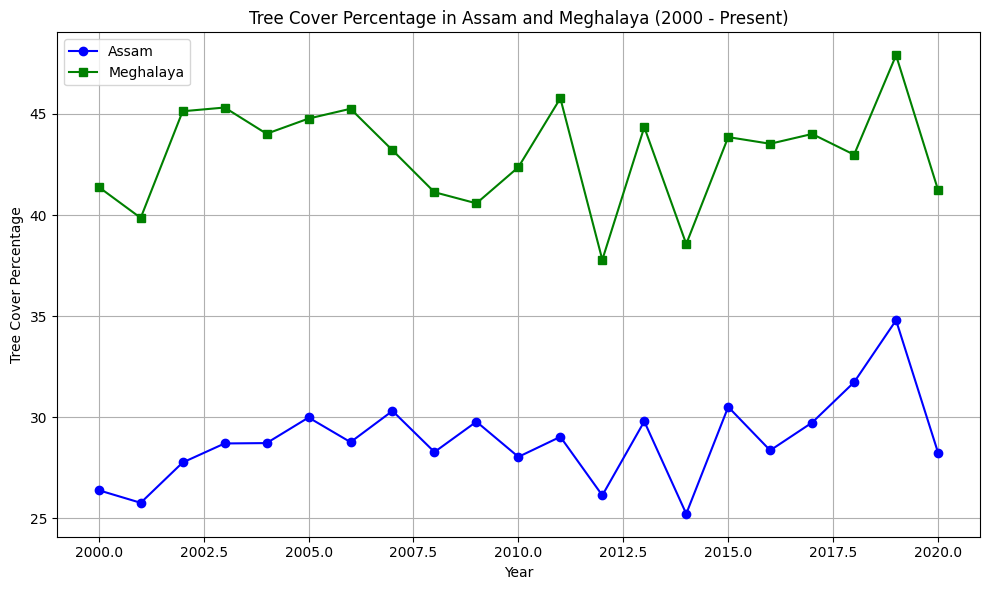

In [23]:
#Displaying change in tree cover percentage in Assam and Meghalaya from 2000 to 2020 using MODIS dataset
import ee
import matplotlib.pyplot as plt

# Initialize the Earth Engine API
ee.Initialize()

# Define the geometry for Assam and Meghalaya (you could replace this with actual boundary data)
india_states = ee.FeatureCollection("FAO/GAUL/2015/level1")
india_states_filtered = india_states.filter(ee.Filter.Or(
    ee.Filter.eq("ADM1_NAME", "Meghalaya"),
    ee.Filter.eq("ADM1_NAME", "Assam")
))

# Load the MODIS Tree Cover dataset
modis_tree_cover = ee.ImageCollection("MODIS/006/MOD44B")

# Function to calculate annual tree cover percentage for a specific state
def calculate_tree_cover_percentage_for_state(state_feature):
    state_name = state_feature.get("ADM1_NAME")  # Get state name
    state_geometry = state_feature.geometry()

    # List of years available in the dataset
    years = ee.List(modis_tree_cover.aggregate_array('system:time_start').map(
        lambda time: ee.Date(time).get('year')
    )).distinct().sort().getInfo()

    # Initialize an array to store results
    annual_tree_cover = []

    for year in years:
        # Filter the collection for the specific year
        yearly_collection = modis_tree_cover.filter(ee.Filter.calendarRange(year, year, 'year'))
        if yearly_collection.size().getInfo() == 0:
            continue  # Skip if no data for the year

        # Get the mean tree cover percentage for the year
        mean_tree_cover = yearly_collection.mean().select('Percent_Tree_Cover').reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=state_geometry,
            scale=500,  # Use the dataset's native resolution
            maxPixels=1e9
        ).get('Percent_Tree_Cover')

        # Retrieve the value (or handle missing data)
        mean_tree_cover_value = ee.Number(mean_tree_cover).getInfo() if mean_tree_cover else None
        annual_tree_cover.append({'year': year, 'tree_cover_percentage': mean_tree_cover_value})

    return annual_tree_cover

# Apply the function to each state (Assam and Meghalaya)
state_tree_cover_data = []
state_features = india_states_filtered.getInfo()['features']

for state_feature in state_features:
    state_tree_cover = calculate_tree_cover_percentage_for_state(ee.Feature(ee.Geometry(state_feature['geometry'])))
    for entry in state_tree_cover:
        state_tree_cover_data.append({
            "State": state_feature['properties']['ADM1_NAME'],
            "Year": entry['year'],
            "Tree Cover Percentage": entry['tree_cover_percentage']
        })

# Prepare data for plotting
assam_data = [data for data in state_tree_cover_data if data['State'] == 'Assam']
meghalaya_data = [data for data in state_tree_cover_data if data['State'] == 'Meghalaya']

assam_years = [data['Year'] for data in assam_data]
assam_tree_cover = [data['Tree Cover Percentage'] for data in assam_data]

meghalaya_years = [data['Year'] for data in meghalaya_data]
meghalaya_tree_cover = [data['Tree Cover Percentage'] for data in meghalaya_data]

# Plotting the data
plt.figure(figsize=(10, 6))

plt.plot(assam_years, assam_tree_cover, label="Assam", color='blue', marker='o')
plt.plot(meghalaya_years, meghalaya_tree_cover, label="Meghalaya", color='green', marker='s')

plt.title("Tree Cover Percentage in Assam and Meghalaya (2000 - Present)")
plt.xlabel("Year")
plt.ylabel("Tree Cover Percentage")
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

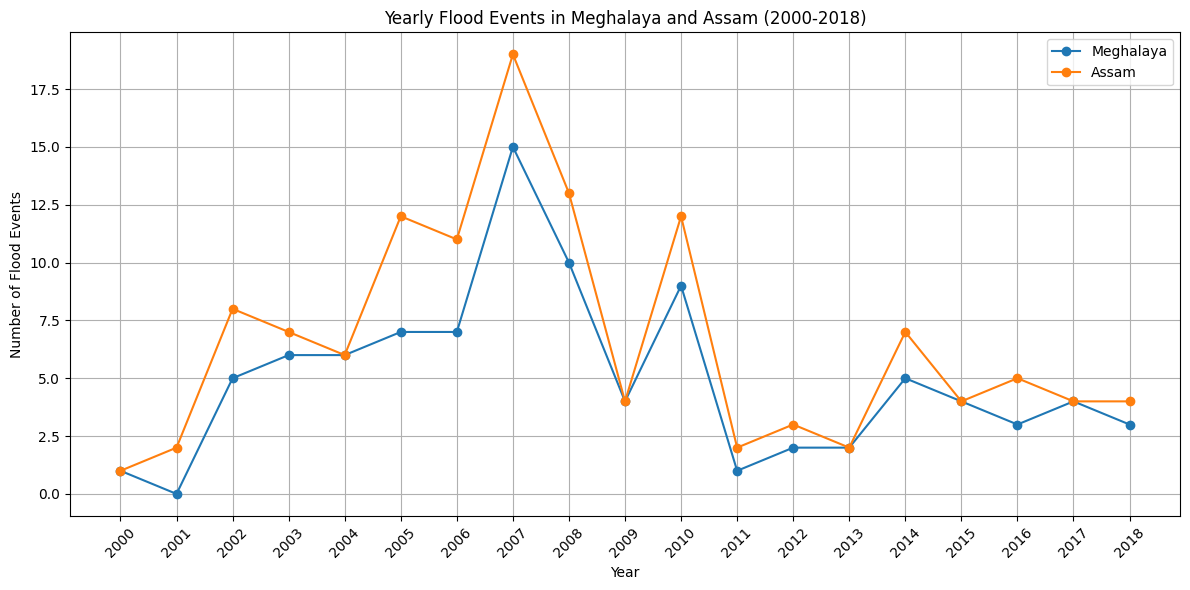

In [28]:
#plotting the temperature data of Indian states from 2000 to 2023 using the ERA5 dataset

# Extract yearly data for Meghalaya and Assam
yearly_flooding_data = {"Meghalaya": {}, "Assam": {}}

for state_feature in state_features:
    state_geometry = ee.Feature(ee.Geometry(state_feature['geometry']))
    state_flooding_fc = get_state_flooding(state_geometry)
    
    # Retrieve yearly flooding data
    state_flooding_list = state_flooding_fc.getInfo()["features"]
    
    state_name = state_feature['properties']['ADM1_NAME']
    for feature in state_flooding_list:
        year = feature["properties"]["year"]
        flood_count = feature["properties"]["flood_event_count"]
        yearly_flooding_data[state_name][year] = flood_count

# Prepare data for plotting
years = list(range(2000, 2019))
meghalaya_floods = [yearly_flooding_data["Meghalaya"].get(year, 0) for year in years]
assam_floods = [yearly_flooding_data["Assam"].get(year, 0) for year in years]

# Plot the graph
plt.figure(figsize=(12, 6))
plt.plot(years, meghalaya_floods, label="Meghalaya", marker="o")
plt.plot(years, assam_floods, label="Assam", marker="o")

# Customize the plot
plt.title("Yearly Flood Events in Meghalaya and Assam (2000-2018)")
plt.xlabel("Year")
plt.ylabel("Number of Flood Events")
plt.xticks(years, rotation=45)
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

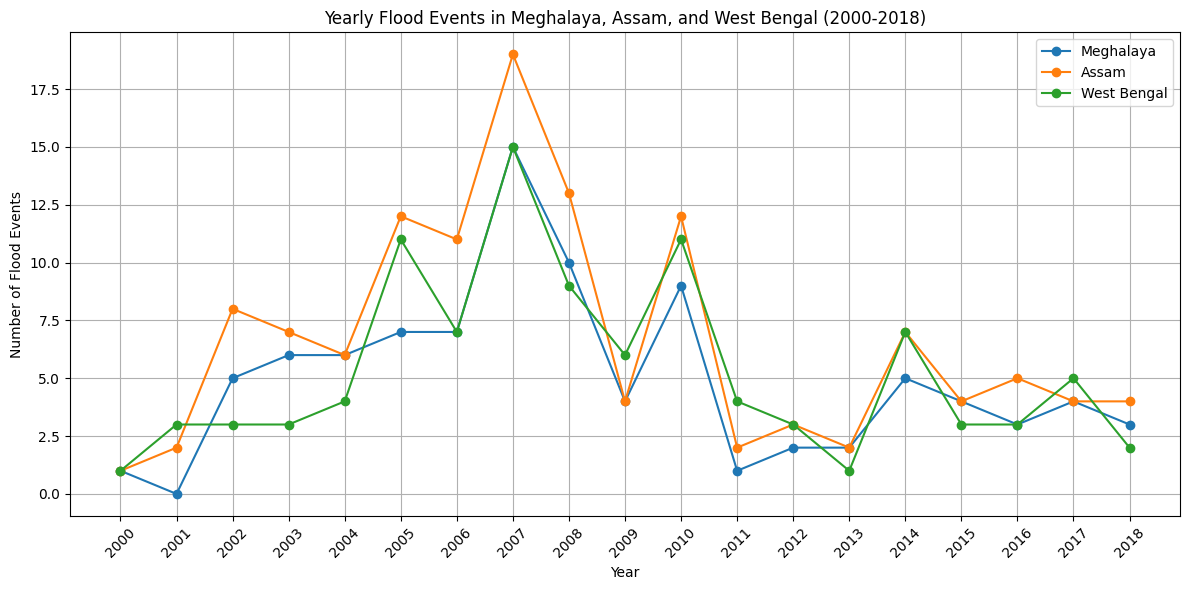

In [29]:
import matplotlib.pyplot as plt

# Add West Bengal to the states of interest
states_of_interest = india_states.filter(
    ee.Filter.Or(
        ee.Filter.eq("ADM1_NAME", "Meghalaya"),
        ee.Filter.eq("ADM1_NAME", "Assam"),
        ee.Filter.eq("ADM1_NAME", "West Bengal")  # Added West Bengal
    )
)

# Extract yearly flooding data for Meghalaya, Assam, and West Bengal
yearly_flooding_data = {"Meghalaya": {}, "Assam": {}, "West Bengal": {}}

for state_feature in states_of_interest.getInfo()['features']:
    state_geometry = ee.Feature(ee.Geometry(state_feature['geometry']))
    state_flooding_fc = get_state_flooding(state_geometry)
    
    # Retrieve yearly flooding data
    state_flooding_list = state_flooding_fc.getInfo()["features"]
    
    state_name = state_feature['properties']['ADM1_NAME']
    for feature in state_flooding_list:
        year = feature["properties"]["year"]
        flood_count = feature["properties"]["flood_event_count"]
        yearly_flooding_data[state_name][year] = flood_count

# Prepare data for plotting
years = list(range(2000, 2019))
meghalaya_floods = [yearly_flooding_data["Meghalaya"].get(year, 0) for year in years]
assam_floods = [yearly_flooding_data["Assam"].get(year, 0) for year in years]
west_bengal_floods = [yearly_flooding_data["West Bengal"].get(year, 0) for year in years]

# Plot the graph
plt.figure(figsize=(12, 6))
plt.plot(years, meghalaya_floods, label="Meghalaya", marker="o")
plt.plot(years, assam_floods, label="Assam", marker="o")
plt.plot(years, west_bengal_floods, label="West Bengal", marker="o")

# Customize the plot
plt.title("Yearly Flood Events in Meghalaya, Assam, and West Bengal (2000-2018)")
plt.xlabel("Year")
plt.ylabel("Number of Flood Events")
plt.xticks(years, rotation=45)
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


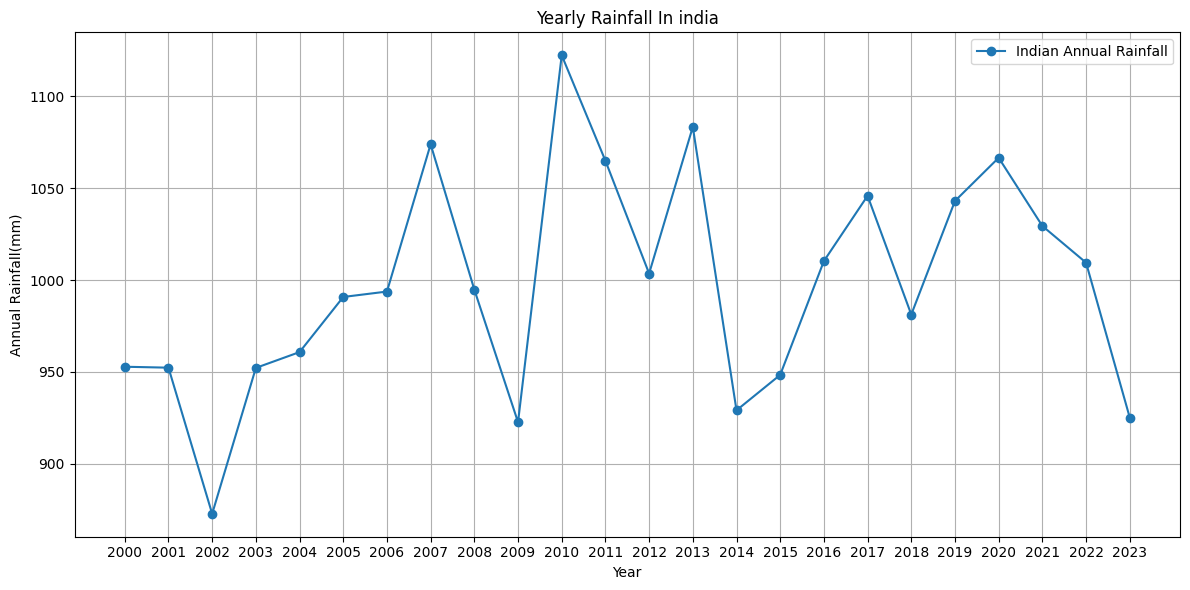

In [70]:
import ee
import matplotlib.pyplot as plt
import pandas as pd
# Initialize Earth Engine API
ee.Initialize()

# Define India Geometry
india_geometry = ee.Geometry.Polygon([
    [[68.1767, 7.9655], [68.1767, 35.5087], [97.4026, 35.5087], [97.4026, 7.9655], [68.1767, 7.9655]]
])

# Load CHIRPS Precipitation Dataset (Rainfall Data)
chirps = ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY") \
    .filterBounds(india_geometry) \
    .filterDate('2000-01-01', '2023-12-31')

# Calculate Total Rainfall per Year
def calculate_annual_rainfall(year):
    start_date = ee.Date.fromYMD(year, 1, 1)
    end_date = start_date.advance(1, 'year')
    annual_rainfall = chirps.filterDate(start_date, end_date).sum()  # Sum rainfall for the year
    annual_rainfall_mean = annual_rainfall.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=india_geometry,
        scale=5000,
        maxPixels=1e9
    ).get('precipitation')
    return ee.Feature(None, {'year': year, 'rainfall': annual_rainfall_mean})

# Generate Annual Rainfall Data for India
years = ee.List.sequence(2000, 2023)
annual_rainfall_fc = ee.FeatureCollection(years.map(calculate_annual_rainfall))

# Get Data as List
rainfall_data = annual_rainfall_fc.getInfo()
rainfall_df = pd.DataFrame(columns=['rainfall', 'year'])

for i in range(24):
    rainfall_df.loc[len(rainfall_df)] = rainfall_data['features'][i]['properties']

years = rainfall_df['year'].values.tolist()

#rainfall_df
plt.figure(figsize=(12, 6))
plt.plot(rainfall_df['year'], rainfall_df['rainfall'], label="Indian Annual Rainfall", marker="o")
plt.title("Yearly Rainfall In india")
plt.xlabel("Year")
plt.ylabel("Annual Rainfall(mm)")
plt.xticks(years)
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

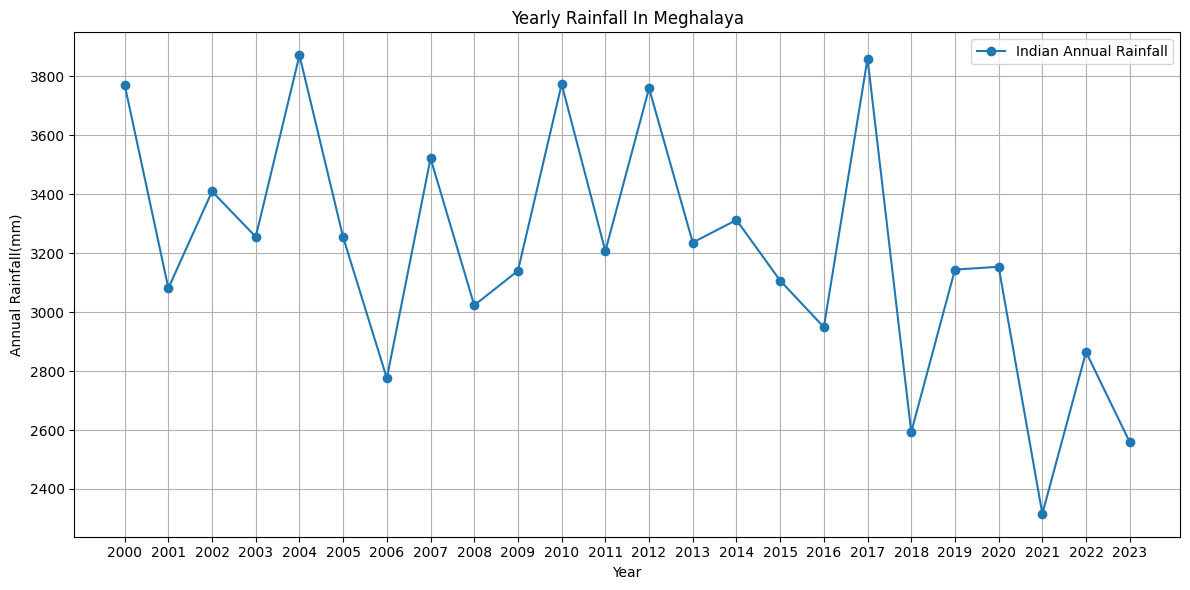

In [89]:
import ee
import matplotlib.pyplot as plt
import pandas as pd
# Initialize Earth Engine API
ee.Initialize()
india_states = ee.FeatureCollection("FAO/GAUL/2015/level1")
india_states_filtered = india_states.filter(ee.Filter.Or(
    ee.Filter.eq("ADM1_NAME", "Meghalaya")
))


# Load CHIRPS Precipitation Dataset (Rainfall Data)
chirps = ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY") \
    .filterBounds(india_states_filtered) \
    .filterDate('2000-01-01', '2023-12-31')

# Calculate Total Rainfall per Year
def calculate_annual_rainfall(year):
    start_date = ee.Date.fromYMD(year, 1, 1)
    end_date = start_date.advance(1, 'year')
    annual_rainfall = chirps.filterDate(start_date, end_date).sum()  # Sum rainfall for the year
    annual_rainfall_mean = annual_rainfall.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=india_states_filtered,
        scale=5000,
        maxPixels=1e9
    ).get('precipitation')
    return ee.Feature(None, {'year': year, 'rainfall': annual_rainfall_mean})

# Generate Annual Rainfall Data for India
years = ee.List.sequence(2000, 2023)
annual_rainfall_fc = ee.FeatureCollection(years.map(calculate_annual_rainfall))

# Get Data as List
rainfall_data = annual_rainfall_fc.getInfo()
rainfall_df = pd.DataFrame(columns=['rainfall', 'year'])

for i in range(24):
    rainfall_df.loc[len(rainfall_df)] = rainfall_data['features'][i]['properties']

years = rainfall_df['year'].values.tolist()

#rainfall_df
plt.figure(figsize=(12, 6))
plt.plot(rainfall_df['year'], rainfall_df['rainfall'], label="Indian Annual Rainfall", marker="o")
plt.title("Yearly Rainfall In Meghalaya")
plt.xlabel("Year")
plt.ylabel("Annual Rainfall(mm)")
plt.xticks(years)
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

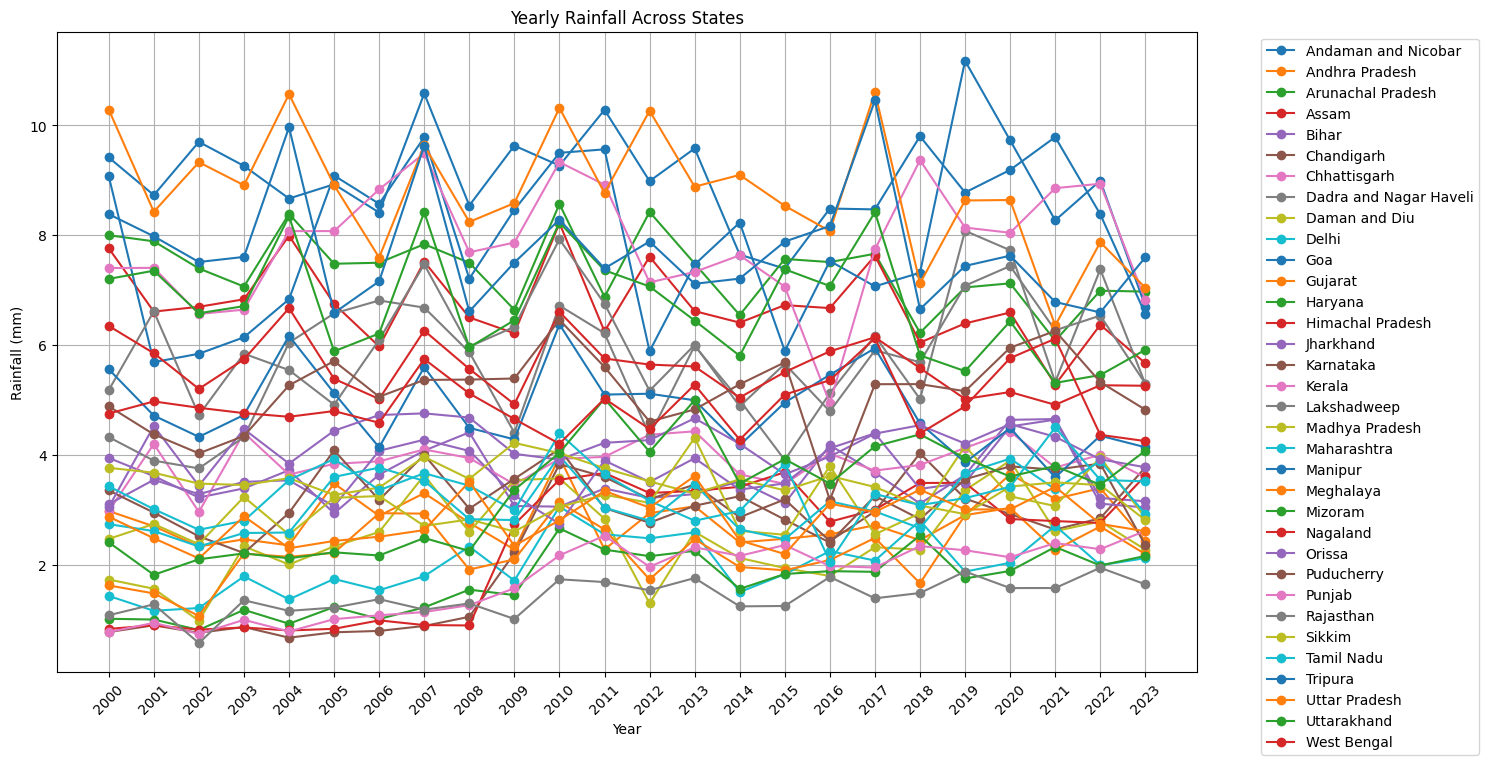

In [106]:
#plot displaying yearly rainfall of every state
import matplotlib.pyplot as plt
rainfall_df = rainfall_df.sort_values(by=['state', 'year'])

# Plot rainfall over the years for each state
plt.figure(figsize=(15, 8))

# Iterate over each state and plot the data
states = rainfall_df['state'].unique()
for state in states:
    state_data = rainfall_df[rainfall_df['state'] == state]
    plt.plot(state_data['year'], state_data['rainfall'], label=state, marker="o")

# Customize the plot
plt.title("Yearly Rainfall Across States")
plt.xlabel("Year")
plt.ylabel("Rainfall (mm)")
plt.xticks(rainfall_df['year'].unique(), rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

Top 5 states with the greatest rainfall variation over the past 20 years:
                     state  rainfall
10                     Goa  1.512311
7   Dadra and Nagar Haveli  1.256106
5               Chandigarh  1.216791
13        Himachal Pradesh  1.203493
21               Meghalaya  1.131899


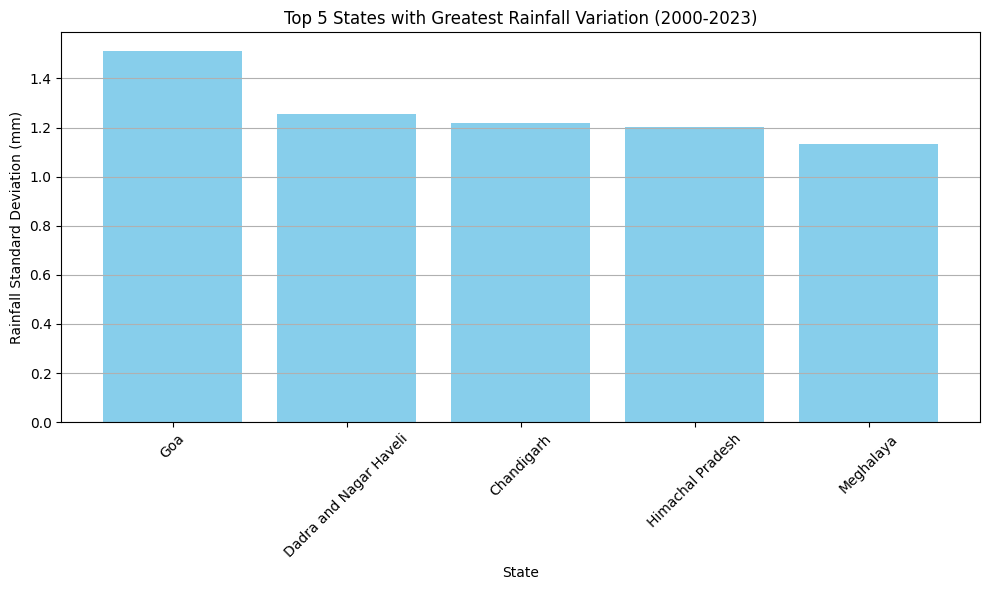

In [107]:
import pandas as pd

# Example DataFrame (replace with your actual data)
# rainfall_df = pd.DataFrame(columns=['rainfall', 'state', 'year'])

# Group by state and calculate the standard deviation of rainfall
rainfall_variation = rainfall_df.groupby('state')['rainfall'].std().reset_index()

# Sort states by descending order of standard deviation
rainfall_variation = rainfall_variation.sort_values(by='rainfall', ascending=False)

# Get the top 5 states with the greatest variation in rainfall
top_states = rainfall_variation.head(5)

print("Top 5 states with the greatest rainfall variation over the past 20 years:")
print(top_states)

# Plot the variation for the top 5 states
plt.figure(figsize=(10, 6))
plt.bar(top_states['state'], top_states['rainfall'], color='skyblue')
plt.title("Top 5 States with Greatest Rainfall Variation (2000-2023)")
plt.xlabel("State")
plt.ylabel("Rainfall Standard Deviation (mm)")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [161]:
import ee
import pandas as pd
# Initialize the Earth Engine API
ee.Initialize()

# Define the geometry for Assam and Meghalaya (you could replace this with actual boundary data)
india_states= ee.FeatureCollection("FAO/GAUL/2015/level1")
india_states_filtered = india_states.filter(ee.Filter.Or(
    ee.Filter.eq("ADM1_NAME", "Daman and Diu"),
    ee.Filter.eq("ADM1_NAME", "Puducherry")
))
# Load the MODIS Tree Cover dataset
modis_tree_cover = ee.ImageCollection("MODIS/006/MOD44B")

# Function to calculate annual tree cover percentage for a specific state
def calculate_tree_cover_percentage_for_state(state_feature):
    state_name = state_feature.get("ADM1_NAME")  # Get state name
    state_geometry = state_feature.geometry()

    # List of years available in the dataset
    years = ee.List(modis_tree_cover.aggregate_array('system:time_start').map(
        lambda time: ee.Date(time).get('year')
    )).distinct().sort().getInfo()

    # Initialize an array to store results
    annual_tree_cover = []

    for year in years:
        # Filter the collection for the specific year
        yearly_collection = modis_tree_cover.filter(ee.Filter.calendarRange(year, year, 'year'))
        if yearly_collection.size().getInfo() == 0:
            continue  # Skip if no data for the year

        # Get the mean tree cover percentage for the year
        mean_tree_cover = yearly_collection.mean().select('Percent_Tree_Cover').reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=state_geometry,
            scale=500,  # Use the dataset's native resolution
            maxPixels=1e9
        ).get('Percent_Tree_Cover')

        # Retrieve the value (or handle missing data)
        mean_tree_cover_value = ee.Number(mean_tree_cover).getInfo() if mean_tree_cover else None
        annual_tree_cover.append({'year': year, 'tree_cover_percentage': mean_tree_cover_value})

    return annual_tree_cover

# Apply the function to each state (Assam and Meghalaya)
state_tree_cover_data = []
state_features = india_states_filtered.getInfo()['features']

for state_feature in state_features:
    state_tree_cover = calculate_tree_cover_percentage_for_state(ee.Feature(ee.Geometry(state_feature['geometry'])))
    for entry in state_tree_cover:
        state_tree_cover_data.append({
            "State": state_feature['properties']['ADM1_NAME'],
            "Year": entry['year'],
            "Tree Cover Percentage": entry['tree_cover_percentage']
        })


tree_df=pd.DataFrame(state_tree_cover_data)
print(tree_df)
tree_df.to_csv("india_forestcover.csv", mode='a', header=False, index=False)

            State  Year  Tree Cover Percentage
0   Daman and Diu  2000               5.339839
1   Daman and Diu  2001               4.257525
2   Daman and Diu  2002               6.667372
3   Daman and Diu  2003               4.489528
4   Daman and Diu  2004               5.652226
5   Daman and Diu  2005               8.104947
6   Daman and Diu  2006               7.229535
7   Daman and Diu  2007               6.067076
8   Daman and Diu  2008               5.562285
9   Daman and Diu  2009               7.739353
10  Daman and Diu  2010               6.288102
11  Daman and Diu  2011               4.932964
12  Daman and Diu  2012               4.862994
13  Daman and Diu  2013               7.291413
14  Daman and Diu  2014               8.016820
15  Daman and Diu  2015               5.846983
16  Daman and Diu  2016               4.782879
17  Daman and Diu  2017               7.508297
18  Daman and Diu  2018               5.223621
19  Daman and Diu  2019               7.997488
20  Daman and

In [181]:
import pandas as pd

# Load the datasets
df_temperature = pd.read_csv("india_temperature.csv")
df_rainfall = pd.read_csv("india_rainfall.csv")
df_forestcover = pd.read_csv("india_forestcover.csv")

# Merge datasets on 'state' and 'year'
df_climate = df_temperature.merge(df_rainfall, on=['State', 'Year'], how='inner')
df_climate = df_climate.merge(df_forestcover, on=['State', 'Year'], how='inner')

# Filter data for years 2000 to 2020
df_climate = df_climate[(df_climate['Year'] >= 2000) & (df_climate['Year'] <= 2020)]

# Save to CSV
df_climate.to_csv("india_climate.csv", index=False)

# Display the first few rows
print(df_climate.head())

   State  Year  Temperature (°C)  rainfall  Tree Cover Percentage
0  Bihar  2000         30.983224  3.948316               7.757197
1  Bihar  2001         31.551800  3.617056               7.582096
2  Bihar  2002         31.573089  3.227402              10.794144
3  Bihar  2003         31.440741  3.393752               8.298599
4  Bihar  2004         31.589823  3.724088               7.619202


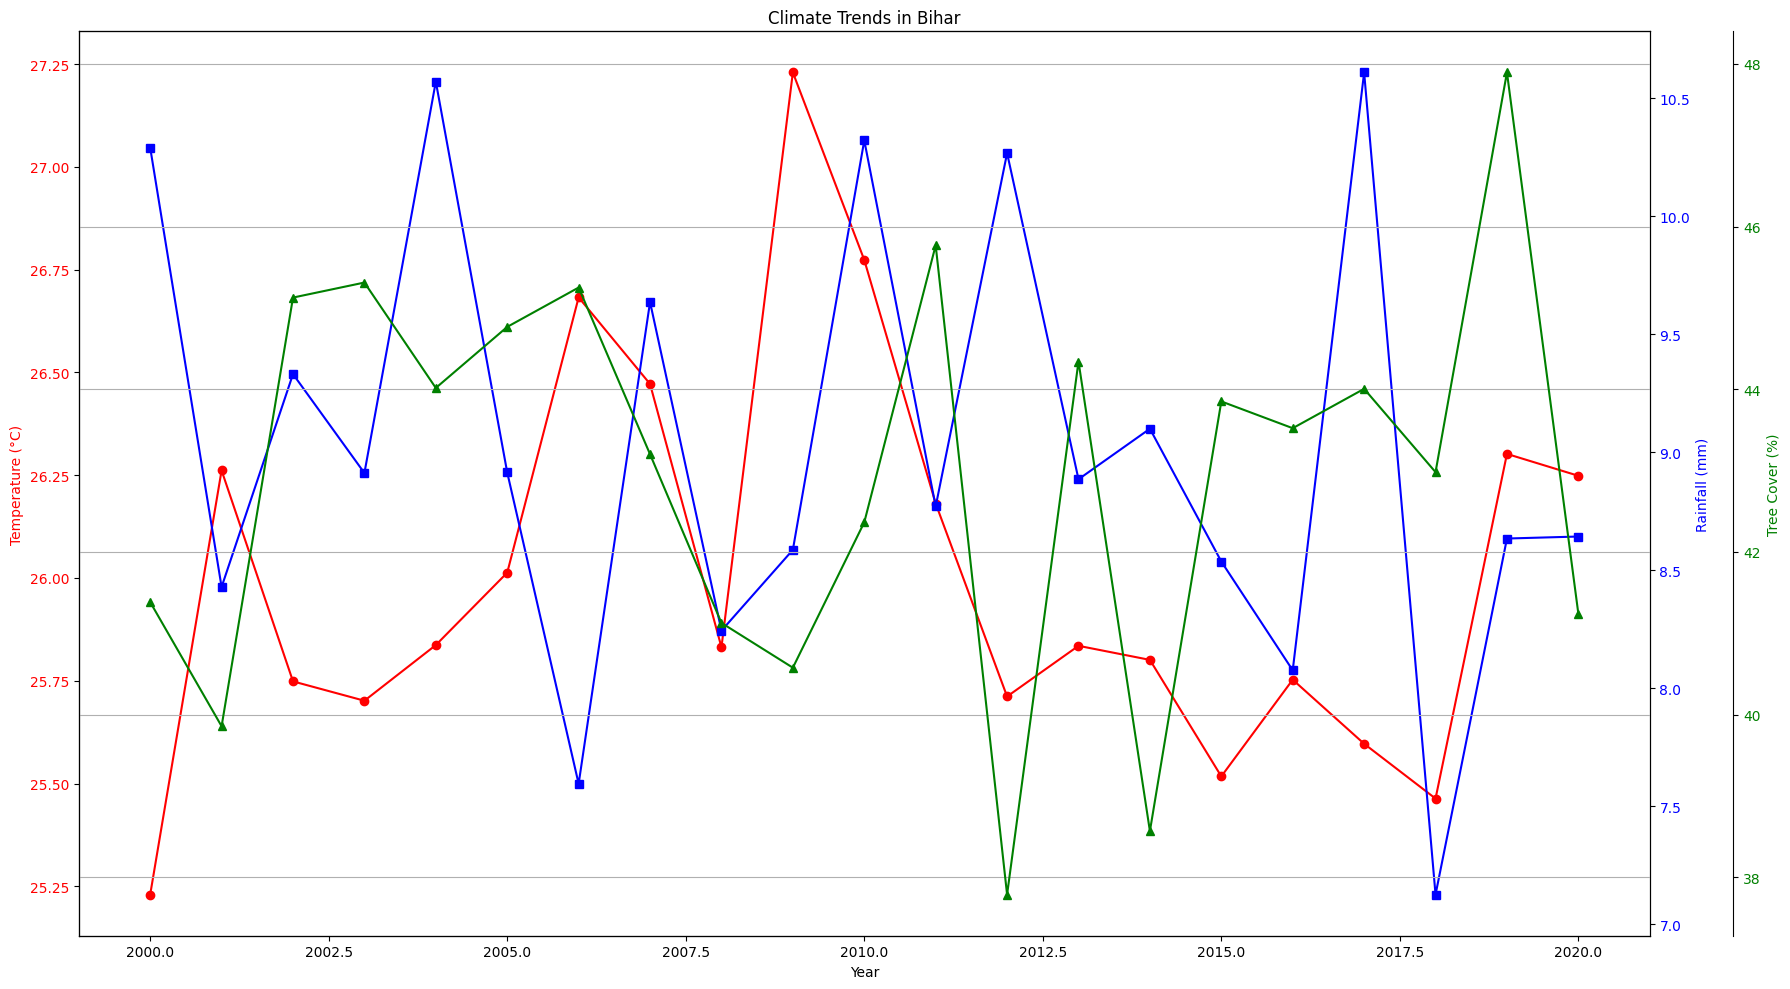

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the climate dataset
df_climate = pd.read_csv("india_climate.csv")

# Filter data for Meghalaya
df_meghalaya = df_climate[df_climate['State'] == 'Meghalaya']

# Ensure data is sorted by year
df_meghalaya = df_meghalaya.sort_values(by='Year')

# Plot setup
fig, ax1 = plt.subplots(figsize=(18, 10))

# Plot temperature
ax1.plot(df_meghalaya['Year'], df_meghalaya['Temperature (°C)'], color='r', marker='o', label="Temperature (°C)")
ax1.set_xlabel("Year")
ax1.set_ylabel("Temperature (°C)", color='r')
ax1.tick_params(axis='y', labelcolor='r')

# Create a second y-axis for rainfall
ax2 = ax1.twinx()
ax2.plot(df_meghalaya['Year'], df_meghalaya['rainfall'], color='b', marker='s', label="Rainfall (mm)")
ax2.set_ylabel("Rainfall (mm)", color='b')
ax2.tick_params(axis='y', labelcolor='b')

# Create a third y-axis for tree cover
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("outward", 60))  # Offset to avoid overlap
ax3.plot(df_meghalaya['Year'], df_meghalaya['Tree Cover Percentage'], color='g', marker='^', label="Tree Cover (%)")
ax3.set_ylabel("Tree Cover (%)", color='g')
ax3.tick_params(axis='y', labelcolor='g')

# Title and grid
plt.title("Climate Trends in Bihar")
fig.tight_layout()
plt.grid(True)

# Show the plot
plt.show()


In [193]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Load the climate dataset
df_climate = pd.read_csv("india_climate.csv")

# Get unique states
states = df_climate['State'].unique()

# Create a directory to save the plots
output_dir = "trr"
os.makedirs(output_dir, exist_ok=True)

# Generate a graph for each state
for state in states:
    df_state = df_climate[df_climate['State'] == state]
    df_state = df_state.sort_values(by='Year')

    # Plot setup
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot temperature
    ax1.plot(df_state['Year'], df_state['Temperature (°C)'], color='r', marker='o', label="Temperature (°C)")
    ax1.set_xlabel("Year")
    ax1.set_ylabel("Temperature (°C)", color='r')
    ax1.tick_params(axis='y', labelcolor='r')

    # Create a second y-axis for rainfall
    ax2 = ax1.twinx()
    ax2.plot(df_state['Year'], df_state['rainfall'], color='b', marker='s', label="Rainfall (mm)")
    ax2.set_ylabel("Rainfall (mm)", color='b')
    ax2.tick_params(axis='y', labelcolor='b')

    # Create a third y-axis for tree cover
    ax3 = ax1.twinx()
    ax3.spines["right"].set_position(("outward", 60))  # Offset to avoid overlap
    ax3.plot(df_state['Year'], df_state['Tree Cover Percentage'], color='g', marker='^', label="Tree Cover (%)")
    ax3.set_ylabel("Tree Cover (%)", color='g')
    ax3.tick_params(axis='y', labelcolor='g')

    # Title and grid
    plt.title(f"Climate Trends in {state} (2000-2020)")
    fig.tight_layout()
    plt.grid(True)

    # Save the plot as an image
    plt.savefig(os.path.join(output_dir, f"{state}_climate_trend.png"))

    # Close the plot to save memory
    plt.close()

print(f"All graphs saved in the '{output_dir}' directory.")


All graphs saved in the 'climate_trends' directory.


/Users/prreddy/Projects/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Filtered dataset saved as meghalaya_monthly_temperature_noaa.csv


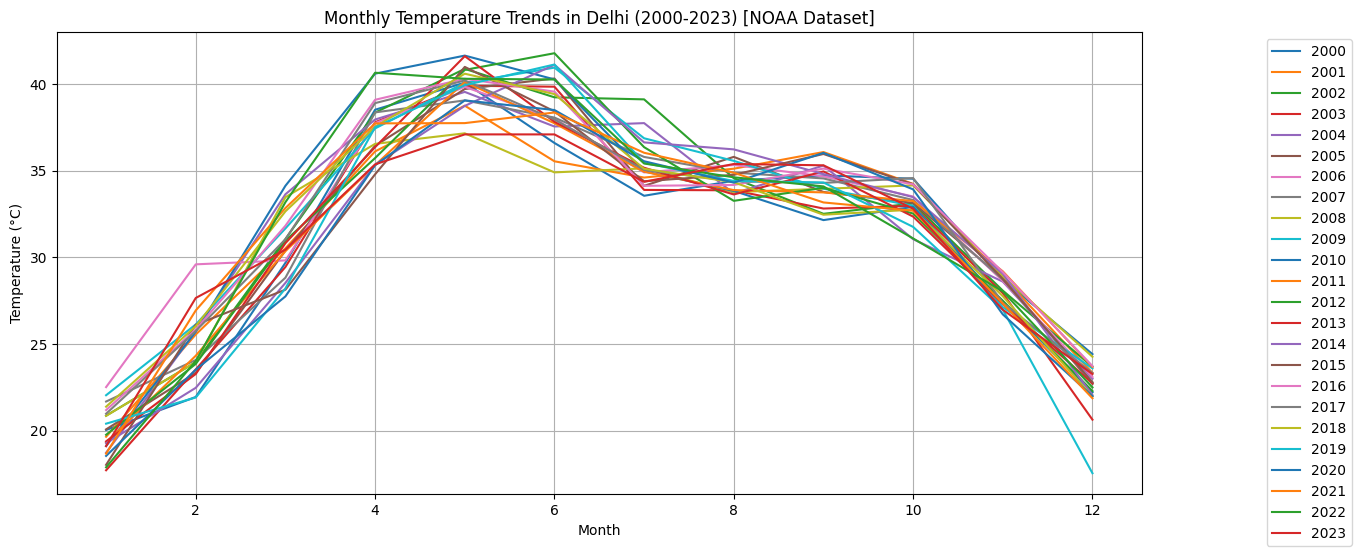

In [1]:
import ee
import pandas as pd
import matplotlib.pyplot as plt

# Initialize the Earth Engine API
ee.Initialize()

# Define the state geometry (Example: Meghalaya)
state_geometry = ee.FeatureCollection("FAO/GAUL/2015/level1") \
    .filter(ee.Filter.eq('ADM1_NAME', 'Delhi')) \
    .geometry()

# Load NOAA/CPC Temperature dataset
temperature_dataset = ee.ImageCollection("NOAA/CPC/Temperature") \
    .filterBounds(state_geometry) \
    .filterDate('2000-01-01', '2023-12-31') \
    .select("tmax")  # Mean temperature

# Function to filter out extreme temperatures
def filter_extreme_temperatures(image):
    mask = image.gte(2.2).And(image.lte(50))  # Keep values between 2.2°C and 50°C
    return image.updateMask(mask)

# Apply the filtering
filtered_temperature = temperature_dataset.map(filter_extreme_temperatures)

# Function to extract monthly temperature (ignoring extreme values)
def get_monthly_temperature(year, month):
    start_date = ee.Date.fromYMD(year, month, 1)
    end_date = start_date.advance(1, 'month')
    
    monthly_temp = filtered_temperature.filterDate(start_date, end_date).mean()
    
    mean_temp = monthly_temp.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=state_geometry,
        scale=5000,
        maxPixels=1e9
    ).get('tmax')
    
    return ee.Feature(None, {'Year': year, 'Month': month, 'Temperature (°C)': mean_temp})

# Generate data for each month from 2000 to 2023
years = list(range(2000, 2024))
months = list(range(1, 13))

features = []
for year in years:
    for month in months:
        features.append(get_monthly_temperature(year, month))

# Convert to FeatureCollection
monthly_temp_fc = ee.FeatureCollection(features)

# Extract data from Earth Engine
temp_data = monthly_temp_fc.getInfo()

# Convert to DataFrame
df_temp = pd.DataFrame([f['properties'] for f in temp_data['features']])

# Save to CSV
df_temp.to_csv("Delhi_monthly_temperature_noaa.csv", index=False)

print("Filtered dataset saved as meghalaya_monthly_temperature_noaa.csv")

# Plot Temperature Trends
plt.figure(figsize=(14, 6))
for year in years:
    subset = df_temp[df_temp['Year'] == year]
    plt.plot(subset['Month'], subset['Temperature (°C)'], label=str(year))

plt.xlabel("Month")
plt.ylabel("Temperature (°C)")
plt.title("Monthly Temperature Trends in Delhi (2000-2023) [NOAA Dataset]")
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1))
plt.grid(True)
plt.show()



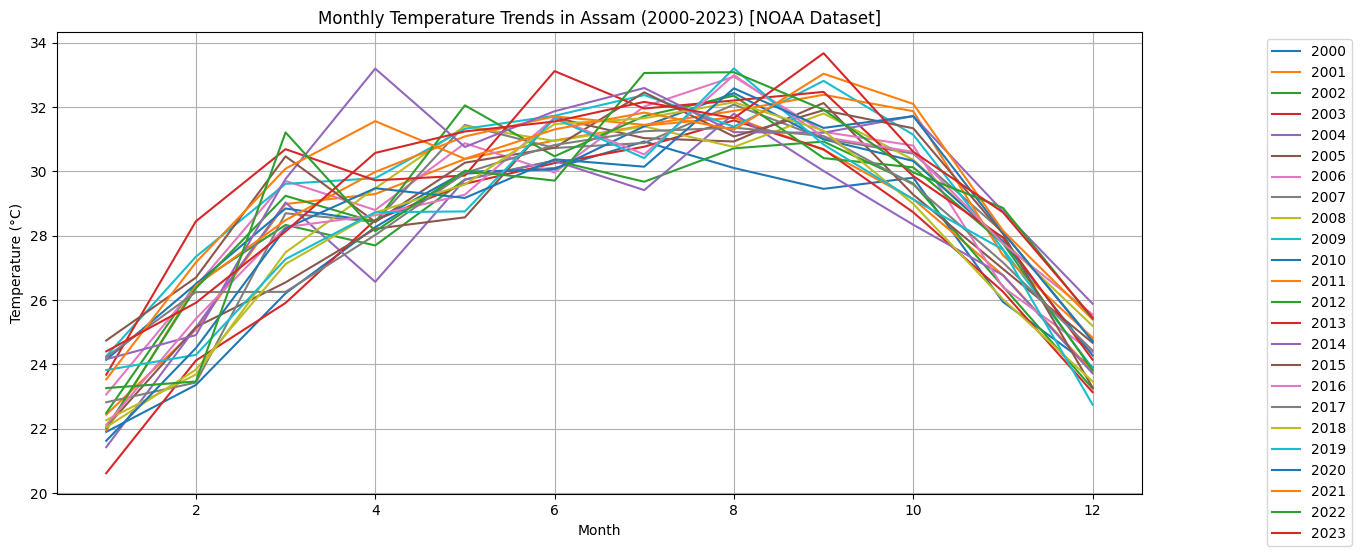

In [6]:
import ee
import pandas as pd
import matplotlib.pyplot as plt

# Initialize the Earth Engine API
ee.Initialize()

# Define the state geometry (Example: Assam)
state_name = 'Assam'
state_geometry = ee.FeatureCollection("FAO/GAUL/2015/level1") \
    .filter(ee.Filter.eq('ADM1_NAME', state_name)) \
    .geometry()

# Load NOAA/CPC Temperature dataset
temperature_dataset = ee.ImageCollection("NOAA/CPC/Temperature") \
    .filterBounds(state_geometry) \
    .filterDate('2000-01-01', '2023-12-31') \
    .select("tmax")  # Mean temperature

# Function to filter out extreme temperatures
def filter_extreme_temperatures(image):
    mask = image.gte(2.2).And(image.lte(50))  # Keep values between 2.2°C and 50°C
    return image.updateMask(mask)

# Apply the filtering
filtered_temperature = temperature_dataset.map(filter_extreme_temperatures)

# Function to extract monthly temperature (ignoring extreme values)
def get_monthly_temperature(year, month):
    start_date = ee.Date.fromYMD(year, month, 1)
    end_date = start_date.advance(1, 'month')
    
    monthly_temp = filtered_temperature.filterDate(start_date, end_date).mean()
    
    mean_temp = monthly_temp.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=state_geometry,
        scale=5000,
        maxPixels=1e9
    ).get('tmax')
    
    return ee.Feature(None, {'State': state_name, 'Year': year, 'Month': month, 'Temperature (°C)': mean_temp})

# Generate data for each month from 2000 to 2023
years = list(range(2000, 2024))
months = list(range(1, 13))

features = []
for year in years:
    for month in months:
        features.append(get_monthly_temperature(year, month))

# Convert to FeatureCollection
monthly_temp_fc = ee.FeatureCollection(features)

# Extract data from Earth Engine
temp_data = monthly_temp_fc.getInfo()

# Convert to DataFrame
df_temp = pd.DataFrame([f['properties'] for f in temp_data['features']])

# Save to CSV
df_temp.to_csv("india_climate_data_2000_2024.csv", index=False)

# Plot Temperature Trends
plt.figure(figsize=(14, 6))
for year in years:
    subset = df_temp[df_temp['Year'] == year]
    plt.plot(subset['Month'], subset['Temperature (°C)'], label=str(year))

plt.xlabel("Month")
plt.ylabel("Temperature (°C)")
plt.title(f"Monthly Temperature Trends in {state_name} (2000-2023) [NOAA Dataset]")
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1))
plt.grid(True)
plt.show()

In [1]:
import ee
import pandas as pd

# Initialize the Earth Engine API
ee.Initialize()

# Define the geometry for Assam and Meghalaya (you could replace this with actual boundary data)
india_states = ee.FeatureCollection("FAO/GAUL/2015/level1")
india_states_filtered = india_states.filter(ee.Filter.Or(
    ee.Filter.eq("ADM1_NAME", "Assam"),
))

# Load the MODIS NDVI dataset for 2007-2008
modis_ndvi = ee.ImageCollection("MODIS/006/MOD13A2") \
    .filterDate("2009-01-01", "2023-12-31")  # Filter for the 2007-2008 period

# Function to calculate monthly forest cover for a specific state
def calculate_monthly_forest_cover_for_state(state_feature, threshold=0.4):
    state_name = state_feature.get("ADM1_NAME").getInfo()  # Get state name
    state_geometry = state_feature.geometry()

    # List of months in 2007-2008
    months = ee.List.sequence(0, 12)
    years = ee.List.sequence(2009, 2023)

    # Initialize an array to store results
    monthly_forest_cover = []

    for year in years.getInfo():
        for month in months.getInfo():
            # Filter the collection for the specific month and year
            monthly_collection = modis_ndvi.filter(ee.Filter.calendarRange(year, year, 'year')) \
                .filter(ee.Filter.calendarRange(month, month, 'month'))

            if monthly_collection.size().getInfo() == 0:
                continue  # Skip if no data for the month

            # Take the mean NDVI for that month
            mean_ndvi = monthly_collection.mean().select('NDVI')
            # Classify each pixel as forest (NDVI > threshold) or non-forest
            forest_mask = mean_ndvi.gt(threshold)  # True for forest, False for non-forest
            # Calculate the total number of pixels
            total_pixels = mean_ndvi.reduceRegion(
                reducer=ee.Reducer.count(),
                geometry=state_geometry,
                scale=500,  # 500m resolution for MODIS
                maxPixels=1e9
            ).get('NDVI')

            # Calculate the number of forest pixels
            forest_pixels = forest_mask.reduceRegion(
                reducer=ee.Reducer.sum(),
                geometry=state_geometry,
                scale=500,
                maxPixels=1e9
            ).get('NDVI')

            # Calculate the percentage of forest pixels
            total_pixels = ee.Number(total_pixels).getInfo() if total_pixels else 0
            forest_pixels = ee.Number(forest_pixels).getInfo() if forest_pixels else 0

            if total_pixels > 0:
                forest_percentage = (forest_pixels / total_pixels) * 100
            else:
                forest_percentage = None

            # Store the result
            monthly_forest_cover.append({
                'State': state_name,
                'Year': year,
                'Month': month,
                'Forest Cover Percentage': forest_percentage
            })

    return monthly_forest_cover

# Apply the function to each state (Assam and Meghalaya)
state_forest_cover_data = []
state_features = india_states_filtered.getInfo()['features']

for state_feature in state_features:
    state_forest_cover = calculate_monthly_forest_cover_for_state(ee.Feature(state_feature))
    for entry in state_forest_cover:
        state_forest_cover_data.append(entry)

# Create a DataFrame from the collected data
forest_cover_df = pd.DataFrame(state_forest_cover_data)

# Print the results
print(forest_cover_df)

# Store the results in a CSV file
forest_cover_df.to_csv("Assam_monthly_forest_cover_percentage2.csv", mode='a', header=False , index=False)

/Users/prreddy/Projects/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/prreddy/Projects/.venv/lib/python3.9/site-packages/ee/deprecation.py:207: DeprecationWarning: 

Attention required for MODIS/006/MOD13A2! You are using a deprecated asset.
To ensure continued functionality, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD13A2

  warnings.warn(warning, category=DeprecationWarning)


     State  Year  Month  Forest Cover Percentage
0    Assam  2009      1                98.988230
1    Assam  2009      2                99.344136
2    Assam  2009      3                99.133195
3    Assam  2009      4                98.767147
4    Assam  2009      5                98.568819
..     ...   ...    ...                      ...
165  Assam  2022     10                97.257625
166  Assam  2022     11                97.766824
167  Assam  2022     12                98.681359
168  Assam  2023      1                98.891054
169  Assam  2023      2                99.154282

[170 rows x 4 columns]


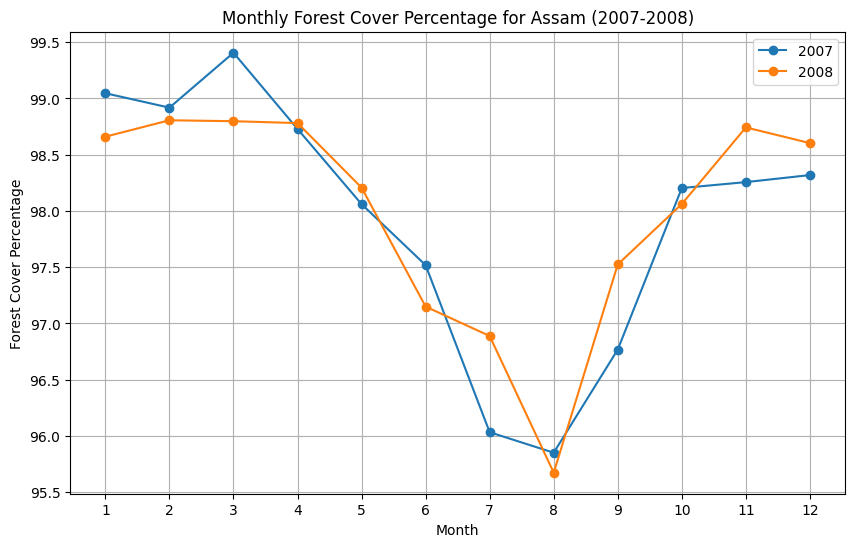

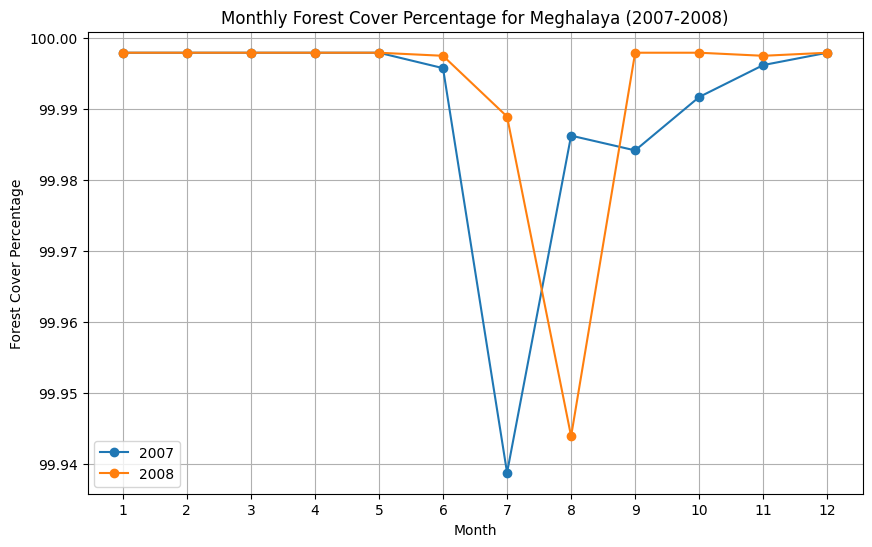

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from the CSV file
file_path = "/Users/prreddy/Projects/india_monthly_forest_cover_percentage_2007_2008.csv"
forest_cover_df = pd.read_csv(file_path)

# Plot the forest cover percentage month-wise for each state
states = forest_cover_df['State'].unique()

for state in states:
    state_data = forest_cover_df[forest_cover_df['State'] == state]
    
    plt.figure(figsize=(10, 6))
    for year in state_data['Year'].unique():
        year_data = state_data[state_data['Year'] == year]
        plt.plot(year_data['Month'], year_data['Forest Cover Percentage'], marker='o', label=f'{year}')
    
    plt.title(f'Monthly Forest Cover Percentage for {state} (2007-2008)')
    plt.xlabel('Month')
    plt.ylabel('Forest Cover Percentage')
    plt.xticks(range(1, 13))
    plt.legend()
    plt.grid(True)
    plt.show()

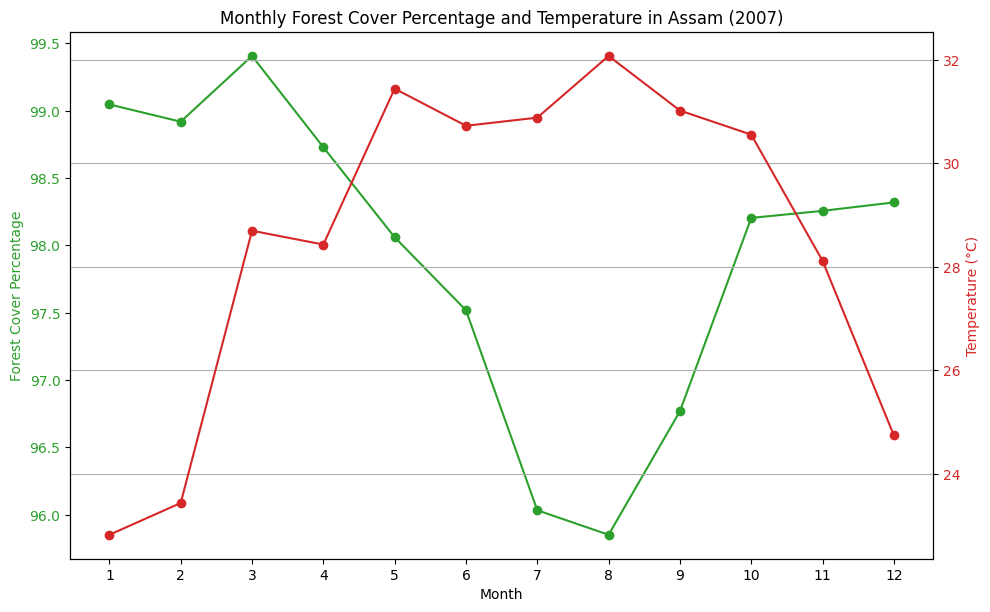

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the forest cover data from the CSV file
forest_cover_df = pd.read_csv("india_monthly_forest_cover_percentage_2007_2008.csv")

# Load the temperature data from the CSV file
temperature_df = pd.read_csv("india_climate_data_2000_2024.csv")

# Filter the data for Assam in 2007
assam_forest_cover_df = forest_cover_df[(forest_cover_df['State'] == 'Assam') & (forest_cover_df['Year'] == 2007)]
assam_temperature_df = temperature_df[(temperature_df['State'] == 'Assam') & (temperature_df['Year'] == 2007)]

# Merge the two dataframes on Month
merged_df = pd.merge(assam_forest_cover_df, assam_temperature_df, on=['State', 'Year', 'Month'])

# Plot the monthly forest cover percentage and temperature for Assam in 2007
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:green'
ax1.set_xlabel('Month')
ax1.set_ylabel('Forest Cover Percentage', color=color)
ax1.plot(merged_df['Month'], merged_df['Forest Cover Percentage'], marker='o', color=color, label='Forest Cover Percentage')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('Temperature (°C)', color=color)  # we already handled the x-label with ax1
ax2.plot(merged_df['Month'], merged_df['Temperature (°C)'], marker='o', color=color, label='Temperature')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Monthly Forest Cover Percentage and Temperature in Assam (2007)')
plt.xticks(range(1, 13))
plt.grid(True)
plt.show()

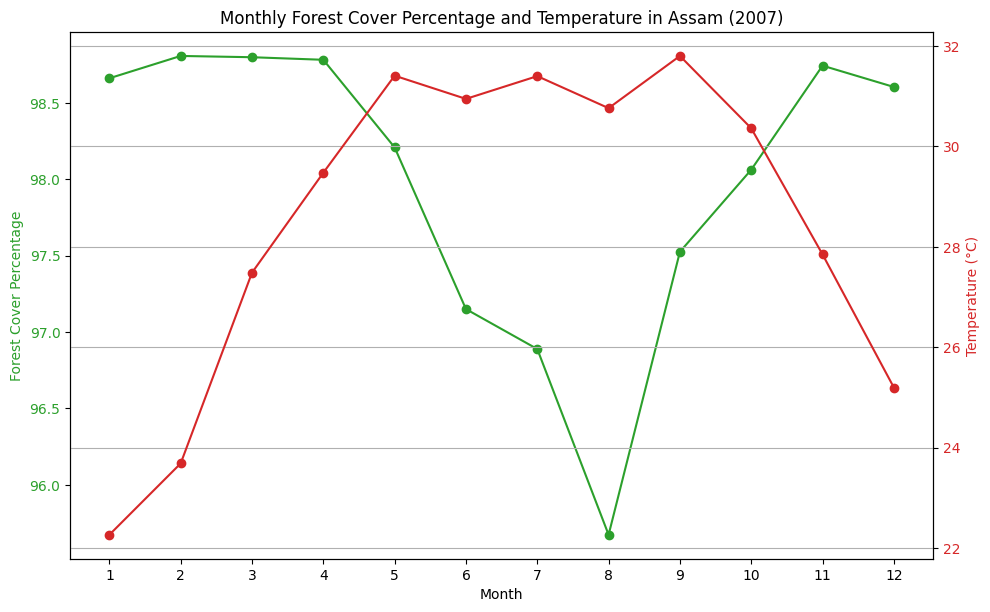

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the forest cover data from the CSV file
forest_cover_df = pd.read_csv("india_monthly_forest_cover_percentage_2007_2008.csv")

# Load the temperature data from the CSV file
temperature_df = pd.read_csv("india_climate_data_2000_2024.csv")

# Filter the data for Assam in 2007
assam_forest_cover_df = forest_cover_df[(forest_cover_df['State'] == 'Assam') & (forest_cover_df['Year'] == 2008)]
assam_temperature_df = temperature_df[(temperature_df['State'] == 'Assam') & (temperature_df['Year'] == 2008)]

# Merge the two dataframes on Month
merged_df = pd.merge(assam_forest_cover_df, assam_temperature_df, on=['State', 'Year', 'Month'])

# Plot the monthly forest cover percentage and temperature for Assam in 2007
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:green'
ax1.set_xlabel('Month')
ax1.set_ylabel('Forest Cover Percentage', color=color)
ax1.plot(merged_df['Month'], merged_df['Forest Cover Percentage'], marker='o', color=color, label='Forest Cover Percentage')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('Temperature (°C)', color=color)  # we already handled the x-label with ax1
ax2.plot(merged_df['Month'], merged_df['Temperature (°C)'], marker='o', color=color, label='Temperature')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Monthly Forest Cover Percentage and Temperature in Assam (2007)')
plt.xticks(range(1, 13))
plt.grid(True)
plt.show()

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Load the forest cover data from the CSV file
forest_cover_df = pd.read_csv("Assam_monthly_forest_cover_percentage.csv")

# Load the temperature data from the CSV file
temperature_df = pd.read_csv("india_climate_data_2000_2024.csv")

# Load the rainfall data from the CSV file
rainfall_df = pd.read_csv("assam_monthly_rainfall_2000_2023.csv")

# Create the output directory if it doesn't exist
output_dir = "assam_temperature_forestcover_rainfall"
os.makedirs(output_dir, exist_ok=True)

# Loop through each year from 2000 to 2023
for year in range(2000, 2024):
    # Filter the data for Assam for the current year
    assam_forest_cover_df = forest_cover_df[(forest_cover_df['State'] == 'Assam') & (forest_cover_df['Year'] == year)]
    assam_temperature_df = temperature_df[(temperature_df['State'] == 'Assam') & (temperature_df['Year'] == year)]
    assam_rainfall_df = rainfall_df[(rainfall_df['State'] == 'Assam') & (rainfall_df['Year'] == year)]

    # Check if there is data for the current year
    if assam_forest_cover_df.empty or assam_temperature_df.empty or assam_rainfall_df.empty:
        print(f"No data available for Assam in {year}")
        continue

    # Merge the dataframes on Month
    merged_df = pd.merge(assam_forest_cover_df, assam_temperature_df, on=['State', 'Year', 'Month'])
    merged_df = pd.merge(merged_df, assam_rainfall_df, on=['State', 'Year', 'Month'])

    # Check if the merged dataframe is empty
    if merged_df.empty:
        print(f"No merged data available for Assam in {year}")
        continue

    # Plot the monthly forest cover percentage, temperature, and rainfall for Assam for the current year
    fig, ax1 = plt.subplots(figsize=(10, 6))

    color = 'tab:green'
    ax1.set_xlabel('Month')
    ax1.set_ylabel('Forest Cover Percentage', color=color)
    ax1.plot(merged_df['Month'], merged_df['Forest Cover Percentage'], marker='o', color=color, label='Forest Cover Percentage')
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:red'
    ax2.set_ylabel('Temperature (°C)', color=color)  # we already handled the x-label with ax1
    ax2.plot(merged_df['Month'], merged_df['Temperature (°C)'], marker='o', color=color, label='Temperature')
    ax2.tick_params(axis='y', labelcolor=color)

    ax3 = ax1.twinx()  # instantiate a third axes that shares the same x-axis
    ax3.spines['right'].set_position(('outward', 60))  # Offset the third y-axis
    color = 'tab:blue'
    ax3.set_ylabel('Rainfall (mm)', color=color)
    ax3.plot(merged_df['Month'], merged_df['Rainfall (mm)'], marker='o', color=color, label='Rainfall')
    ax3.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title(f'Monthly Forest Cover Percentage, Temperature, and Rainfall in Assam ({year})')
    plt.xticks(range(1, 13))
    plt.grid(True)

    # Save the plot to the output directory
    plt.savefig(os.path.join(output_dir, f'assam_temperature_forestcover_{year}.png'))
    plt.close(fig)  # Close the figure to free up memory

    print(f"Plot saved for Assam in {year}")

Plot saved for Assam in 2000
Plot saved for Assam in 2001
Plot saved for Assam in 2002
Plot saved for Assam in 2003
Plot saved for Assam in 2004
Plot saved for Assam in 2005
Plot saved for Assam in 2006
Plot saved for Assam in 2007
Plot saved for Assam in 2008
Plot saved for Assam in 2009
Plot saved for Assam in 2010
Plot saved for Assam in 2011
Plot saved for Assam in 2012
Plot saved for Assam in 2013
Plot saved for Assam in 2014
Plot saved for Assam in 2015
Plot saved for Assam in 2016
Plot saved for Assam in 2017
Plot saved for Assam in 2018
Plot saved for Assam in 2019
Plot saved for Assam in 2020
Plot saved for Assam in 2021
Plot saved for Assam in 2022
Plot saved for Assam in 2023


In [2]:
import ee
import pandas as pd
from tqdm import tqdm

# Initialize the Earth Engine API
ee.Initialize()

# Load India's state boundaries
states = ee.FeatureCollection("FAO/GAUL/2015/level1")  # Example dataset with global states
india_states = states.filter(ee.Filter.eq("ADM0_NAME", "India"))  # Filter for Indian states

# Filter for Assam
assam = india_states.filter(ee.Filter.eq("ADM1_NAME", "Assam"))

# Load CHIRPS daily rainfall dataset
chirps = ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY")

# Function to calculate monthly rainfall for Assam
def get_monthly_rainfall(state_feature):
    state_name = state_feature.get("ADM1_NAME").getInfo()  # State name
    geometry = state_feature.geometry()

    # List of years and months
    years = ee.List.sequence(1981, 2023)
    months = ee.List.sequence(1, 12)

    # Initialize an array to store results
    monthly_rainfall = []

    for year in years.getInfo():
        for month in months.getInfo():
            # Filter dataset to the region and month
            start_date = ee.Date.fromYMD(year, month, 1)
            end_date = start_date.advance(1, "month")
            monthly_rainfall_image = chirps.filterBounds(geometry).filterDate(start_date, end_date).mean()

            # Calculate the mean rainfall for the month
            mean_rainfall = monthly_rainfall_image.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=geometry,
                scale=4000,
                maxPixels=1e9
            ).get("precipitation")

            # Store the result
            monthly_rainfall.append({
                'State': state_name,
                'Year': year,
                'Month': month,
                'Rainfall (mm)': mean_rainfall.getInfo() if mean_rainfall else None
            })

    return monthly_rainfall

# Apply the function to Assam
assam_feature = assam.first()
assam_monthly_rainfall = get_monthly_rainfall(assam_feature)

# Convert the result to a DataFrame
rainfall_df = pd.DataFrame(assam_monthly_rainfall)

# Save to CSV
rainfall_df.to_csv("assam_monthly_rainfall_2000_2023.csv",mode='a' ,index=False)

# Print the results
print(rainfall_df)

     State  Year  Month  Rainfall (mm)
0    Assam  1981      1       1.285603
1    Assam  1981      2       1.206150
2    Assam  1981      3       4.245502
3    Assam  1981      4       5.948816
4    Assam  1981      5      13.097272
..     ...   ...    ...            ...
511  Assam  2023      8      11.258939
512  Assam  2023      9       6.608310
513  Assam  2023     10       4.611422
514  Assam  2023     11       0.815617
515  Assam  2023     12       0.414418

[516 rows x 4 columns]


Mann-Kendall Trend Test Results:
Forest Cover Percentage: Mann_Kendall_Test(trend='no trend', h=np.False_, p=np.float64(0.33335824348826115), z=np.float64(-0.967371717271359), Tau=np.float64(-0.14492753623188406), s=np.float64(-40.0), var_s=1625.3333333333333, slope=np.float64(-0.017734078861183125), intercept=np.float64(98.43570184955053))
Temperature (°C): Mann_Kendall_Test(trend='no trend', h=np.False_, p=np.float64(0.5683377615538607), z=np.float64(0.5705012691600322), Tau=np.float64(0.08695652173913043), s=np.float64(24.0), var_s=1625.3333333333333, slope=np.float64(0.05014364821448786), intercept=np.float64(29.33923284889867))
Rainfall (mm): Mann_Kendall_Test(trend='no trend', h=np.False_, p=np.float64(0.7849697273207377), z=np.float64(-0.27284843307653717), Tau=np.float64(-0.043478260869565216), s=np.float64(-12.0), var_s=1625.3333333333333, slope=np.float64(-0.04288037448179505), intercept=np.float64(5.803967655462303))


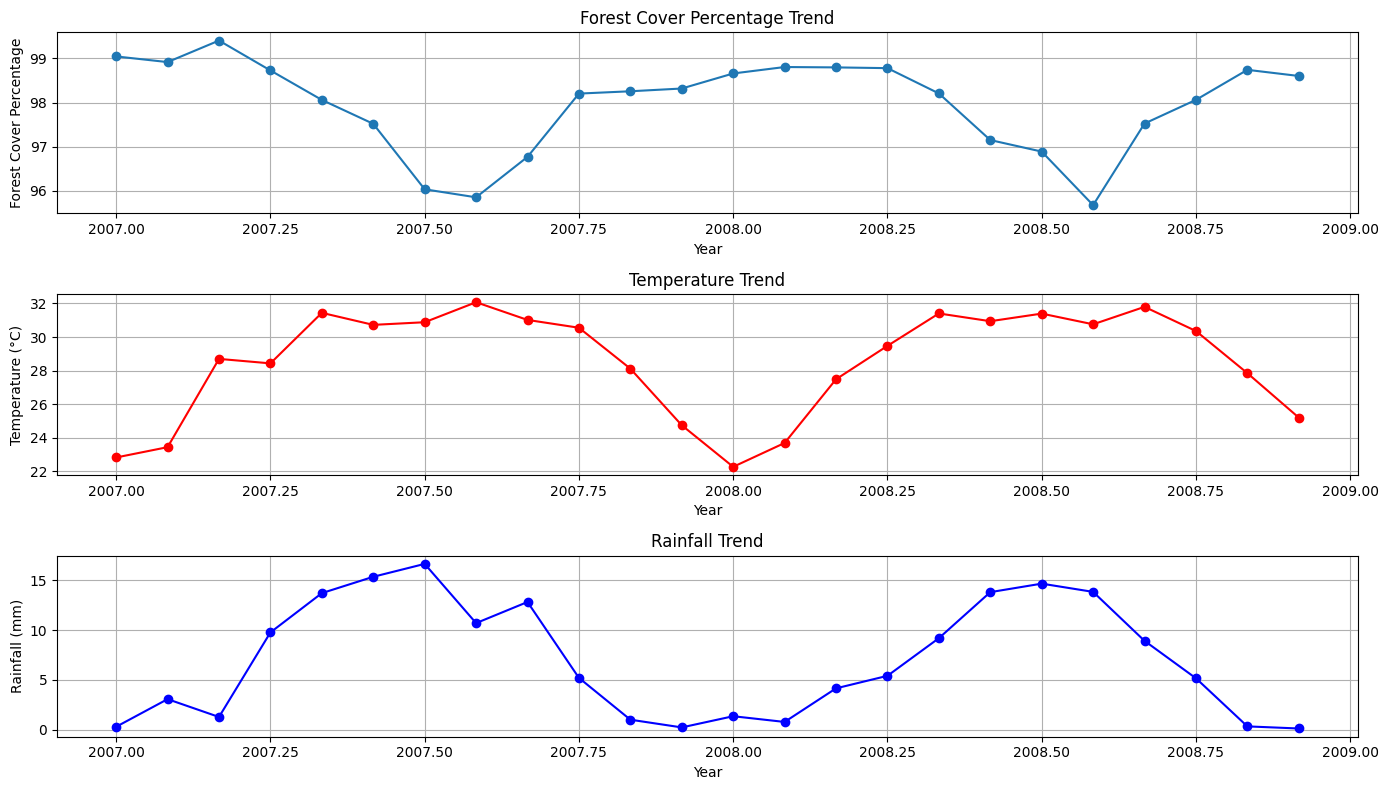

In [2]:
#Test to see if there is a pattern between temperature ,rainfall and forest cover for whole of India
import pandas as pd
import matplotlib.pyplot as plt
from pymannkendall import original_test as mk_test

# Load the forest cover data from the CSV file
forest_cover_df = pd.read_csv("india_monthly_forest_cover_percentage_2007_2008.csv")

# Load the temperature data from the CSV file
temperature_df = pd.read_csv("india_climate_data_2000_2024.csv")

# Load the rainfall data from the CSV file
rainfall_df = pd.read_csv("assam_monthly_rainfall_2000_2023.csv")

# Filter the data for Assam
assam_forest_cover_df = forest_cover_df[forest_cover_df['State'] == 'Assam']
assam_temperature_df = temperature_df[temperature_df['State'] == 'Assam']
assam_rainfall_df = rainfall_df[rainfall_df['State'] == 'Assam']

# Merge the dataframes on Year and Month
merged_df = pd.merge(assam_forest_cover_df, assam_temperature_df, on=['State', 'Year', 'Month'])
merged_df = pd.merge(merged_df, assam_rainfall_df, on=['State', 'Year', 'Month'])

# Rename columns for clarity
merged_df.rename(columns={
    'Forest Cover Percentage': 'Forest_Cover_Percentage',
    'Temperature (°C)': 'Temperature_C',
    'Rainfall (mm)': 'Rainfall_mm'
}, inplace=True)

# Perform the Mann-Kendall trend test
forest_cover_trend = mk_test(merged_df['Forest_Cover_Percentage'])
temperature_trend = mk_test(merged_df['Temperature_C'])
rainfall_trend = mk_test(merged_df['Rainfall_mm'])

# Print the results
print("Mann-Kendall Trend Test Results:")
print(f"Forest Cover Percentage: {forest_cover_trend}")
print(f"Temperature (°C): {temperature_trend}")
print(f"Rainfall (mm): {rainfall_trend}")

# Plot the trends
plt.figure(figsize=(14, 8))

plt.subplot(3, 1, 1)
plt.plot(merged_df['Year'] + (merged_df['Month'] - 1) / 12, merged_df['Forest_Cover_Percentage'], marker='o', label='Forest Cover Percentage')
plt.title('Forest Cover Percentage Trend')
plt.xlabel('Year')
plt.ylabel('Forest Cover Percentage')
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(merged_df['Year'] + (merged_df['Month'] - 1) / 12, merged_df['Temperature_C'], marker='o', color='red', label='Temperature (°C)')
plt.title('Temperature Trend')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(merged_df['Year'] + (merged_df['Month'] - 1) / 12, merged_df['Rainfall_mm'], marker='o', color='blue', label='Rainfall (mm)')
plt.title('Rainfall Trend')
plt.xlabel('Year')
plt.ylabel('Rainfall (mm)')
plt.grid(True)

plt.tight_layout()
plt.show()

In [1]:
import ee
import pandas as pd
from tqdm import tqdm

# Initialize the Earth Engine API
ee.Initialize()

# Load India's state boundaries
states = ee.FeatureCollection("FAO/GAUL/2015/level1")  # Example dataset with global states
india_states = states.filter(ee.Filter.eq("ADM0_NAME", "India"))  # Filter for Indian states

# Filter for Assam
assam = india_states.filter(ee.Filter.eq("ADM1_NAME", "Assam"))

# Load CHIRPS daily rainfall dataset
chirps = ee.ImageCollection("NOAA/CPC/Temperature")

# Function to calculate monthly rainfall for Assam
def get_monthly_rainfall(state_feature):
    state_name = state_feature.get("ADM1_NAME").getInfo()  # State name
    geometry = state_feature.geometry()

    # List of years and months
    years = ee.List.sequence(2000, 2023)
    months = ee.List.sequence(1, 12)

    # Initialize an array to store results
    monthly_rainfall = []

    for year in years.getInfo():
        for month in months.getInfo():
            # Filter dataset to the region and month
            start_date = ee.Date.fromYMD(year, month, 1)
            end_date = start_date.advance(1, "month")
            monthly_rainfall_image = chirps.filterBounds(geometry).filterDate(start_date, end_date).mean()

            # Calculate the mean rainfall for the month
            mean_rainfall = monthly_rainfall_image.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=geometry,
                scale=4000,
                maxPixels=1e9
            ).get("tmax")

            # Store the result
            monthly_rainfall.append({
                'Month': month,
                'State': state_name,
                'Temperature (°C)': mean_rainfall.getInfo() if mean_rainfall else None ,
                'Year': year
            })

    return monthly_rainfall

# Apply the function to Assam
assam_feature = assam.first()
assam_monthly_rainfall = get_monthly_rainfall(assam_feature)

# Convert the result to a DataFrame
rainfall_df = pd.DataFrame(assam_monthly_rainfall)

# Save to CSV
rainfall_df.to_csv("india_climate_data_1981_1999_reordered.csv",mode='a' ,index=False)

# Print the results
print(rainfall_df)

/Users/prreddy/Projects/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


     Month  State  Temperature (°C)  Year
0        1  Assam         21.880043  2000
1        2  Assam         23.333687  2000
2        3  Assam         26.177627  2000
3        4  Assam         28.237541  2000
4        5  Assam         29.903470  2000
..     ...    ...               ...   ...
283      8  Assam         31.627987  2023
284      9  Assam         33.644652  2023
285     10  Assam         30.585109  2023
286     11  Assam         28.701932  2023
287     12  Assam         25.436306  2023

[288 rows x 4 columns]


In [28]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Load the temperature data from the CSV file
temperature_df = pd.read_csv("india_climate_data_2000_2024.csv")

# Load the rainfall data from the CSV file
rainfall_df = pd.read_csv("assam_monthly_rainfall_2000_2023.csv")

# Filter the data for Assam
assam_temperature_df = temperature_df[temperature_df['State'] == 'Assam']
assam_rainfall_df = rainfall_df[rainfall_df['State'] == 'Assam']

# Create the output directory if it doesn't exist
output_dir = "assam_temperature_rainfall"
os.makedirs(output_dir, exist_ok=True)

# Loop through each year from 1981 to 2023
years = list(range(1981, 2024))
for year in years:
    # Filter the data for Assam for the current year
    yearly_temperature_df = assam_temperature_df[assam_temperature_df['Year'] == year]
    yearly_rainfall_df = assam_rainfall_df[assam_rainfall_df['Year'] == year]

    # Check if there is data for the current year
    if yearly_temperature_df.empty or yearly_rainfall_df.empty:
        print(f"No data available for Assam in {year}")
        continue

    # Merge the dataframes on Month
    merged_df = pd.merge(yearly_temperature_df, yearly_rainfall_df, on=['State', 'Year', 'Month'])

    # Check if the merged dataframe is empty
    if merged_df.empty:
        print(f"No merged data available for Assam in {year}")
        continue

    # Plot the monthly temperature and rainfall for Assam for the current year
    fig, ax1 = plt.subplots(figsize=(12, 8))

    color = 'tab:red'
    ax1.set_xlabel('Month')
    ax1.set_ylabel('Temperature (°C)', color=color)
    ax1.plot(merged_df['Month'], merged_df['Temperature (°C)'], marker='o', color=color, label='Temperature (°C)')
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:blue'
    ax2.set_ylabel('Rainfall (mm)', color=color)  # we already handled the x-label with ax1
    ax2.plot(merged_df['Month'], merged_df['Rainfall (mm)'], marker='o', color=color, label='Rainfall (mm)')
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title(f'Monthly Temperature and Rainfall in Assam ({year})')
    plt.xticks(range(1, 13))
    plt.grid(True)

    # Save the plot to the output directory
    plt.savefig(os.path.join(output_dir, f'assam_temperature_rainfall_{year}.png'))
    plt.close(fig)  # Close the figure to free up memory

    print(f"Plot saved for Assam in {year}")

Plot saved for Assam in 1981
Plot saved for Assam in 1982
Plot saved for Assam in 1983
Plot saved for Assam in 1984
Plot saved for Assam in 1985
Plot saved for Assam in 1986
Plot saved for Assam in 1987
Plot saved for Assam in 1988
Plot saved for Assam in 1989
Plot saved for Assam in 1990
Plot saved for Assam in 1991
Plot saved for Assam in 1992
Plot saved for Assam in 1993
Plot saved for Assam in 1994
Plot saved for Assam in 1995
Plot saved for Assam in 1996
Plot saved for Assam in 1997
Plot saved for Assam in 1998
Plot saved for Assam in 1999
Plot saved for Assam in 2000
Plot saved for Assam in 2001
Plot saved for Assam in 2002
Plot saved for Assam in 2003
Plot saved for Assam in 2004
Plot saved for Assam in 2005
Plot saved for Assam in 2006
Plot saved for Assam in 2007
Plot saved for Assam in 2008
Plot saved for Assam in 2009
Plot saved for Assam in 2010
Plot saved for Assam in 2011
Plot saved for Assam in 2012
Plot saved for Assam in 2013
Plot saved for Assam in 2014
Plot saved for

In [17]:
#getting a trecover dataset using  NOAA/CDR/AVHRR/NDVI/V5
import ee
import pandas as pd

# Initialize the Earth Engine API
ee.Initialize()

# Define Assam state boundary
assam_geometry = ee.FeatureCollection("FAO/GAUL/2015/level1") \
    .filter(ee.Filter.eq('ADM1_NAME', 'Assam')) \
    .geometry()

# Load NOAA CDR AVHRR NDVI dataset
ndvi_dataset = ee.ImageCollection("NOAA/CDR/AVHRR/NDVI/V5") \
    .filterBounds(assam_geometry) \
    .select("NDVI")

# Function to compute tree cover percentage for a given month
def get_tree_cover_percentage(year, month):
    # Define start and end date for the month
    start_date = ee.Date.fromYMD(year, month, 1)
    end_date = start_date.advance(1, 'month')

    # Filter NDVI for the specific month and compute the mean
    monthly_ndvi = ndvi_dataset.filterDate(start_date, end_date).mean().clip(assam_geometry)

    # Check if the image has bands before dividing
    band_count = monthly_ndvi.bandNames().size().getInfo()
    if band_count == 0:
        return ee.Feature(None, {'Year': year, 'Month': month, 'Tree Cover %': None})

    monthly_ndvi = monthly_ndvi.divide(10000)

    # Apply tree cover threshold (NDVI ≥ 0.325)
    tree_cover_mask = monthly_ndvi.gte(0.325)

    # Compute tree-covered area (in square kilometers)
    tree_cover_area = tree_cover_mask.multiply(ee.Image.pixelArea()).divide(1e6).reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=assam_geometry,
        scale=5000,
        maxPixels=1e9
    ).get('NDVI')

    # Compute total Assam area (in square kilometers)
    total_area = assam_geometry.area().divide(1e6)

    # Compute tree cover percentage
    tree_cover_percentage = ee.Number(tree_cover_area).divide(total_area).multiply(100)

    # Return result as a feature
    return ee.Feature(None, {'Year': year, 'Month': month, 'Tree Cover %': tree_cover_percentage})

# Generate data for each month from 2000 to 2023
years = list(range(2000, 2024))
months = list(range(1, 13))

# Create feature collection
features = []
for year in years:
    for month in months:
        features.append(get_tree_cover_percentage(year, month))

# Convert to FeatureCollection
monthly_tree_cover_fc = ee.FeatureCollection(features)

# Extract data from Earth Engine
tree_cover_data = monthly_tree_cover_fc.getInfo()

# Convert to DataFrame
df_tree_cover = pd.DataFrame([f['properties'] for f in tree_cover_data['features']])

# Save to CSV
df_tree_cover.to_csv("assam_monthly_tree_cover_2000_2023_3.csv", index=False)

# Print confirmation
print("Tree cover percentage data saved as assam_monthly_tree_cover_2000_2023.csv")


Tree cover percentage data saved as assam_monthly_tree_cover_2000_2023.csv


In [5]:
import ee
import pandas as pd

# Initialize the Earth Engine API
ee.Initialize()

# Load the district boundaries for Assam
districts = ee.FeatureCollection("FAO/GAUL/2015/level2") \
    .filter(ee.Filter.eq('ADM1_NAME', 'Assam'))

# Load NOAA CDR AVHRR NDVI dataset
ndvi_dataset = ee.ImageCollection("NOAA/CDR/AVHRR/NDVI/V5") \
    .filterBounds(districts) \
    .select("NDVI")

# Function to compute tree cover percentage for a given month and district
def get_tree_cover_percentage(year, month, district):
    district_name = district.get('ADM2_NAME').getInfo()
    district_geometry = district.geometry()

    # Define start and end date for the month
    start_date = ee.Date.fromYMD(year, month, 1)
    end_date = start_date.advance(1, 'month')

    # Filter NDVI for the specific month
    monthly_ndvi_collection = ndvi_dataset.filterDate(start_date, end_date)
    
    # Check if the collection is empty
    if monthly_ndvi_collection.size().getInfo() == 0:
        return ee.Feature(None, {'Year': year, 'Month': month, 'District': district_name, 'Tree Cover %': None})
    
    # Compute the mean NDVI and scale it
    monthly_ndvi = monthly_ndvi_collection.mean().multiply(0.0001).clip(district_geometry)

    # Apply tree cover threshold (NDVI ≥ 0.3)
    tree_cover_area = monthly_ndvi.updateMask(monthly_ndvi.gte(0.3)).multiply(ee.Image.pixelArea()).divide(1e6).reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=district_geometry,
        scale=5000,
        maxPixels=1e9
    ).get('NDVI')

    # Compute total district area (in square kilometers)
    total_area = district_geometry.area().divide(1e6).getInfo()

    # Compute tree cover percentage
    tree_cover_percentage = ee.Number(tree_cover_area).divide(total_area).multiply(100)

    # Return result as a feature
    return ee.Feature(None, {'Year': year, 'Month': month, 'District': district_name, 'Tree Cover %': tree_cover_percentage})

# Generate data for each month from 1981 to 2023 for each district
years = list(range(1981, 1982))
months = list(range(1, 13))

# Create feature collection
features = []
district_list = districts.getInfo()['features']
for district in district_list:
    district_feature = ee.Feature(district)
    for year in years:
        for month in months:
            features.append(get_tree_cover_percentage(year, month, district_feature))

# Convert to FeatureCollection
monthly_tree_cover_fc = ee.FeatureCollection(features)

# Extract data from Earth Engine
tree_cover_data = monthly_tree_cover_fc.getInfo()

# Convert to DataFrame
df_tree_cover = pd.DataFrame([f['properties'] for f in tree_cover_data['features']])

# Save to CSV
df_tree_cover.to_csv("assam_district_monthly_tree_cover_1981_2023.csv", index=False)

# Print confirmation
print("Tree cover percentage data saved as assam_district_monthly_tree_cover_1981_2023.csv")

Tree cover percentage data saved as assam_district_monthly_tree_cover_1981_2023.csv


In [6]:
import ee
import pandas as pd
import concurrent.futures

# Initialize the Earth Engine API
ee.Initialize()

# Load the district boundaries for Assam
districts = ee.FeatureCollection("FAO/GAUL/2015/level2") \
    .filter(ee.Filter.eq('ADM1_NAME', 'Assam'))

# Load NOAA/CPC Temperature dataset
temperature_dataset = ee.ImageCollection("NOAA/CPC/Temperature") \
    .filterBounds(districts) \
    .select("tmax")  # Maximum temperature

# Function to compute monthly temperature for a given month and district
def get_monthly_temperature(year, month, district):
    district_name = district.get('ADM2_NAME').getInfo()
    district_geometry = district.geometry()

    # Define start and end date for the month
    start_date = ee.Date.fromYMD(year, month, 1)
    end_date = start_date.advance(1, 'month')

    # Filter temperature data for the specific month
    monthly_temp_collection = temperature_dataset.filterDate(start_date, end_date)
    
    # Check if the collection is empty
    if monthly_temp_collection.size().getInfo() == 0:
        return {'Year': year, 'Month': month, 'District': district_name, 'Temperature (°C)': None}
    
    # Compute the mean temperature
    monthly_temp = monthly_temp_collection.mean().clip(district_geometry)

    # Calculate the mean temperature for the district
    mean_temp = monthly_temp.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=district_geometry,
        scale=5000,
        maxPixels=1e9
    ).get('tmax')

    # Return result as a dictionary
    return {'Year': year, 'Month': month, 'District': district_name, 'Temperature (°C)': mean_temp.getInfo()}

# Generate data for each month from 1981 to 2023 for each district
years = list(range(1981, 2024))
months = list(range(1, 13))

# Create a list of tasks for multi-threading
tasks = []
district_list = districts.getInfo()['features']
for district in district_list:
    district_feature = ee.Feature(district)
    for year in years:
        for month in months:
            tasks.append((year, month, district_feature))

# Function to process a single task
def process_task(task):
    year, month, district_feature = task
    return get_monthly_temperature(year, month, district_feature)

# Use multi-threading to process tasks
with concurrent.futures.ThreadPoolExecutor() as executor:
    results = list(executor.map(process_task, tasks))

# Convert results to DataFrame
df_temperature = pd.DataFrame(results)

# Save to CSV
df_temperature.to_csv("assam_district_monthly_temperature_1981_2023.csv", index=False)

# Print confirmation
print("Temperature data saved as assam_district_monthly_temperature_1981_2023.csv")

Temperature data saved as assam_district_monthly_temperature_1981_2023.csv


In [16]:
#stores the monthly rainfall data for each district in a state
import ee
import pandas as pd
import concurrent.futures

# Initialize the Earth Engine API
ee.Initialize()

# Load the district boundaries for Assam
districts = ee.FeatureCollection("FAO/GAUL/2015/level2") \
    .filter(ee.Filter.eq('ADM1_NAME', 'Assam'))

# Load CHIRPS daily rainfall dataset
rainfall_dataset = ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY") \
    .filterBounds(districts) \
    .select("precipitation")

# Function to compute monthly rainfall for a given month and district
def get_monthly_rainfall(year, month, district):
    district_name = district.get('ADM2_NAME').getInfo()
    district_geometry = district.geometry()

    # Define start and end date for the month
    start_date = ee.Date.fromYMD(year, month, 1)
    end_date = start_date.advance(1, 'month')

    # Filter rainfall data for the specific month
    monthly_rainfall_collection = rainfall_dataset.filterDate(start_date, end_date)
    
    # Check if the collection is empty
    if monthly_rainfall_collection.size().getInfo() == 0:
        return {'Year': year, 'Month': month, 'District': district_name, 'Rainfall (mm)': None}
    
    # Compute the total rainfall for the month
    total_rainfall = monthly_rainfall_collection.sum().clip(district_geometry)

    # Calculate the mean rainfall for the district
    mean_rainfall = total_rainfall.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=district_geometry,
        scale=5000,
        maxPixels=1e9
    ).get('precipitation')

    # Return result as a dictionary
    return {'Year': year, 'Month': month, 'District': district_name, 'Rainfall (mm)': mean_rainfall.getInfo()}

# Generate data for each month from 1981 to 2023 for each district
years = list(range(1981, 2024))
months = list(range(1, 13))

# Create a list of tasks for multi-threading
tasks = []
district_list = districts.getInfo()['features']
for district in district_list:
    district_feature = ee.Feature(district)
    for year in years:
        for month in months:
            tasks.append((year, month, district_feature))

# Function to process a single task
def process_task(task):
    year, month, district_feature = task
    return get_monthly_rainfall(year, month, district_feature)

# Use multi-threading to process tasks
with concurrent.futures.ThreadPoolExecutor() as executor:
    results = list(executor.map(process_task, tasks))

# Convert results to DataFrame
df_rainfall = pd.DataFrame(results)

# Save to CSV
df_rainfall.to_csv("assam_district_monthly_rainfall_1981_2023.csv", index=False)

# Print confirmation
print("Rainfall data saved as assam_district_monthly_rainfall_1981_2023.csv")

Rainfall data saved as assam_district_monthly_rainfall_1981_2023.csv


In [27]:
#creates and stores a scatter plot to find correlqaion between temperature and rainfall
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load the temperature and rainfall data from the CSV files
temperature_file_path = "/Users/prreddy/Projects/assam_district_monthly_temperature_1981_2023.csv"
rainfall_file_path = "/Users/prreddy/Projects/assam_district_monthly_rainfall_1981_2023.csv"

temperature_df = pd.read_csv(temperature_file_path, skiprows=1, names=['Year', 'Month', 'District', 'Temperature (°C)'])
rainfall_df = pd.read_csv(rainfall_file_path, skiprows=1, names=['Year', 'Month', 'District', 'Rainfall (mm)'])

# Convert columns to appropriate data types
temperature_df['Year'] = temperature_df['Year'].astype(int)
temperature_df['Month'] = temperature_df['Month'].astype(int)
temperature_df['Temperature (°C)'] = temperature_df['Temperature (°C)'].astype(float)

rainfall_df['Year'] = rainfall_df['Year'].astype(int)
rainfall_df['Month'] = rainfall_df['Month'].astype(int)
rainfall_df['Rainfall (mm)'] = rainfall_df['Rainfall (mm)'].astype(float)

# Merge the temperature and rainfall data on Year, Month, and District
merged_df = pd.merge(temperature_df, rainfall_df, on=['Year', 'Month', 'District'])

# Create the output directory if it doesn't exist
output_dir = "assam_district_temp_rainfall_plots"
os.makedirs(output_dir, exist_ok=True)

# Get the list of unique districts
districts = merged_df['District'].unique()

# Loop through each district and analyze the relationship between temperature and rainfall
for district in districts:
    district_df = merged_df[merged_df['District'] == district]
    
    # Perform correlation analysis
    correlation = district_df[['Temperature (°C)', 'Rainfall (mm)']].corr().iloc[0, 1]
    
    # Plotting
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=district_df, x='Rainfall (mm)', y='Temperature (°C)', hue='Year', palette='viridis', alpha=0.7)
    
    # Customizing the graph
    plt.title(f"Temperature vs Rainfall in {district} (1981-2023)\nCorrelation: {correlation:.2f}", fontsize=16)
    plt.xlabel("Rainfall (mm)", fontsize=14)
    plt.ylabel("Temperature (°C)", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    
    # Save the plot to the output directory
    plt.savefig(os.path.join(output_dir, f'{district}_temp_vs_rainfall.png'))
    plt.close()  # Close the figure to free up memory

    print(f"Plot saved for {district}")

print("All plots saved.")

Plot saved for Barpeta
Plot saved for Cachar
Plot saved for Darrang
Plot saved for Dhuburi
Plot saved for Dibrugarh
Plot saved for Goalpara
Plot saved for Golaghat
Plot saved for Kamrup
Plot saved for Karbi Anglong
Plot saved for Karimganj
Plot saved for Nagaon
Plot saved for Nalbari
Plot saved for North Cachar Hills
Plot saved for Sibsagar
Plot saved for Sonitpur
Plot saved for Bongaigaon
Plot saved for Dhemaji
Plot saved for Hailakandi
Plot saved for Jorhat
Plot saved for Kokrajhar
Plot saved for Lakhimpur
Plot saved for Marigaon
Plot saved for Tinsukia
All plots saved.


In [30]:
#Runs a test to check if there is a pattern or correlation between temperature, rainfall and tree cover
import pandas as pd
import numpy as np
import os
from pymannkendall import original_test as mk_test

# Load the temperature, tree cover, and rainfall data from the CSV files
temperature_file_path = "/Users/prreddy/Projects/assam_district_monthly_temperature_1981_2023.csv"
rainfall_file_path = "/Users/prreddy/Projects/assam_district_monthly_rainfall_1981_2023.csv"
tree_cover_file_path = "/Users/prreddy/Projects/assam_district_annual_tree_cover_2000_2020.csv"

temperature_df = pd.read_csv(temperature_file_path)
rainfall_df = pd.read_csv(rainfall_file_path)
tree_cover_df = pd.read_csv(tree_cover_file_path)

# Filter data for the years 2000 to 2020
temperature_df = temperature_df[(temperature_df['Year'] >= 2000) & (temperature_df['Year'] <= 2020)]
rainfall_df = rainfall_df[(rainfall_df['Year'] >= 2000) & (rainfall_df['Year'] <= 2020)]
tree_cover_df = tree_cover_df[(tree_cover_df['Year'] >= 2000) & (tree_cover_df['Year'] <= 2020)]

# Calculate the annual mean temperature and total rainfall for each district
annual_temperature = temperature_df.groupby(['Year', 'District'])['Temperature (°C)'].mean().reset_index()
annual_rainfall = rainfall_df.groupby(['Year', 'District'])['Rainfall (mm)'].sum().reset_index()

# Merge the dataframes on Year and District
merged_df = pd.merge(annual_temperature, annual_rainfall, on=['Year', 'District'])
merged_df = pd.merge(merged_df, tree_cover_df, on=['Year', 'District'])

# Create the output directory if it doesn't exist
output_dir = "assam_district_mk_test_results"
os.makedirs(output_dir, exist_ok=True)

# Get the list of unique districts
districts = merged_df['District'].unique()

# Initialize a list to store the results
results = []

# Loop through each district and perform the Mann-Kendall test
for district in districts:
    district_df = merged_df[merged_df['District'] == district]
    
    # Perform the Mann-Kendall test for temperature
    temp_trend = mk_test(district_df['Temperature (°C)'])
    
    # Perform the Mann-Kendall test for rainfall
    rainfall_trend = mk_test(district_df['Rainfall (mm)'])
    
    # Perform the Mann-Kendall test for tree cover
    tree_cover_trend = mk_test(district_df['Tree Cover (%)'])
    
    # Store the results
    results.append({
        'District': district,
        'Temperature Trend': temp_trend.trend,
        'Temperature p-value': temp_trend.p,
        'Rainfall Trend': rainfall_trend.trend,
        'Rainfall p-value': rainfall_trend.p,
        'Tree Cover Trend': tree_cover_trend.trend,
        'Tree Cover p-value': tree_cover_trend.p
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Save to CSV
results_df.to_csv(os.path.join(output_dir, "assam_district_mk_test_results_2000_2020.csv"), index=False)

# Print confirmation
print("Mann-Kendall test results saved as assam_district_mk_test_results_2000_2020.csv")

Mann-Kendall test results saved as assam_district_mk_test_results_2000_2020.csv


In [45]:
#Storin tree cover data of a state at the district level
import ee
import pandas as pd
import concurrent.futures

# Initialize the Earth Engine API
ee.Initialize()

def get_tree_cover_data(state_name, start_year=2000, end_year=2020, output_file="{state_name}_tree_cover_data.csv"):
    # Load the district boundaries for the specified state
    districts = ee.FeatureCollection("FAO/GAUL/2015/level2") \
        .filter(ee.Filter.eq('ADM1_NAME', state_name))

    # Load MODIS tree cover dataset
    tree_cover_dataset = ee.ImageCollection("MODIS/006/MOD44B") \
        .filterBounds(districts) \
        .select("Percent_Tree_Cover")

    # Function to compute annual tree cover for a given year and district
    def get_annual_tree_cover(year, district):
        district_name = district.get('ADM2_NAME').getInfo()
        district_geometry = district.geometry()

        # Define start and end date for the year
        start_date = ee.Date.fromYMD(year, 1, 1)
        end_date = ee.Date.fromYMD(year, 12, 31)

        # Filter tree cover data for the specific year
        annual_tree_cover_collection = tree_cover_dataset.filterDate(start_date, end_date)
        
        # Check if the collection is empty
        if annual_tree_cover_collection.size().getInfo() == 0:
            return {'Year': year, 'District': district_name, 'Tree Cover (%)': None}
        
        # Compute the mean tree cover for the year
        mean_tree_cover = annual_tree_cover_collection.mean().clip(district_geometry)

        # Calculate the mean tree cover for the district
        mean_tree_cover_value = mean_tree_cover.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=district_geometry,
            scale=500,
            maxPixels=1e9
        ).get('Percent_Tree_Cover')

        # Return result as a dictionary
        return {'Year': year, 'District': district_name, 'Tree Cover (%)': mean_tree_cover_value.getInfo()}

    # Generate data for each year from start_year to end_year for each district
    years = list(range(start_year, end_year + 1))

    # Create a list of tasks for multi-threading
    tasks = []
    district_list = districts.getInfo()['features']
    for district in district_list:
        district_feature = ee.Feature(district)
        for year in years:
            tasks.append((year, district_feature))

    # Function to process a single task
    def process_task(task):
        year, district_feature = task
        return get_annual_tree_cover(year, district_feature)

    # Use multi-threading to process tasks
    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = list(executor.map(process_task, tasks))

    # Convert results to DataFrame
    df_tree_cover = pd.DataFrame(results)

    # Save to CSV
    df_tree_cover.to_csv(output_file, index=False)

    # Print confirmation
    print(f"Tree cover data saved as {output_file}")

state_name = "Kerala"
get_tree_cover_data(f"{state_name}", 2000, 2020, f"{state_name}_tree_cover_data.csv")

Tree cover data saved as Kerala_tree_cover_data.csv


In [1]:
import ee
import pandas as pd
import concurrent.futures

# Initialize the Earth Engine API
ee.Authenticate()
ee.Initialize()

def get_rainfall_data(state_name, start_year=1981, end_year=2023, output_file="rainfall_data.csv"):
    # Load the district boundaries for the specified state
    districts = ee.FeatureCollection("FAO/GAUL/2015/level2") \
        .filter(ee.Filter.eq('ADM1_NAME', state_name))

    # Load CHIRPS daily rainfall dataset
    rainfall_dataset = ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY") \
        .filterBounds(districts) \
        .select("precipitation")

    # Function to compute monthly rainfall for a given month and district
    def get_monthly_rainfall(year, month, district):
        district_name = district.get('ADM2_NAME').getInfo()
        district_geometry = district.geometry()

        # Define start and end date for the month
        start_date = ee.Date.fromYMD(year, month, 1)
        end_date = start_date.advance(1, 'month')

        # Filter rainfall data for the specific month
        monthly_rainfall_collection = rainfall_dataset.filterDate(start_date, end_date)
        
        # Check if the collection is empty
        if monthly_rainfall_collection.size().getInfo() == 0:
            return {'Year': year, 'Month': month, 'District': district_name, 'Rainfall (mm)': None}
        
        # Compute the total rainfall for the month
        total_rainfall = monthly_rainfall_collection.sum().clip(district_geometry)

        # Calculate the mean rainfall for the district
        mean_rainfall = total_rainfall.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=district_geometry,
            scale=5000,
            maxPixels=1e9
        ).get('precipitation')

        # Return result as a dictionary
        return {'Year': year, 'Month': month, 'District': district_name, 'Rainfall (mm)': mean_rainfall.getInfo()}

    # Generate data for each month from start_year to end_year for each district
    years = list(range(start_year, end_year + 1))
    months = list(range(1, 13))

    # Create a list of tasks for multi-threading
    tasks = []
    district_list = districts.getInfo()['features']
    for district in district_list:
        district_feature = ee.Feature(district)
        for year in years:
            for month in months:
                tasks.append((year, month, district_feature))

    # Function to process a single task
    def process_task(task):
        year, month, district_feature = task
        return get_monthly_rainfall(year, month, district_feature)

    # Use multi-threading to process tasks
    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = list(executor.map(process_task, tasks))

    # Convert results to DataFrame
    df_rainfall = pd.DataFrame(results)

    # Save to CSV
    df_rainfall.to_csv(output_file, index=False)

    # Print confirmation
    print(f"Rainfall data saved as {output_file}")

state_name = "Assam"
get_rainfall_data(f"{state_name}", 2000, 2020, f"{state_name}_district_monthly_rainfall_2000_2020.csv")

/Users/prreddy/Projects/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Rainfall data saved as Assam_district_monthly_rainfall_2000_2020.csv


In [50]:
#Storing the temperature data in a csv file for the state at the district level
import ee
import pandas as pd
import concurrent.futures

# Initialize the Earth Engine API
ee.Initialize()

def get_temperature_data(state_name, start_year=1981, end_year=2023, output_file="temperature_data.csv"):
    # Load the district boundaries for the specified state
    districts = ee.FeatureCollection("FAO/GAUL/2015/level2") \
        .filter(ee.Filter.eq('ADM1_NAME', state_name))

    # Load NOAA/CPC Temperature dataset
    temperature_dataset = ee.ImageCollection("NOAA/CPC/Temperature") \
        .filterBounds(districts) \
        .select("tmax")  # Maximum temperature

    # Function to compute monthly temperature for a given month and district
    def get_monthly_temperature(year, month, district):
        district_name = district.get('ADM2_NAME').getInfo()
        district_geometry = district.geometry()

        # Define start and end date for the month
        start_date = ee.Date.fromYMD(year, month, 1)
        end_date = start_date.advance(1, 'month')

        # Filter temperature data for the specific month
        monthly_temp_collection = temperature_dataset.filterDate(start_date, end_date)
        
        # Check if the collection is empty
        if monthly_temp_collection.size().getInfo() == 0:
            return {'Year': year, 'Month': month, 'District': district_name, 'Temperature (°C)': None}
        
        # Compute the mean temperature
        monthly_temp = monthly_temp_collection.mean().clip(district_geometry)

        # Calculate the mean temperature for the district
        mean_temp = monthly_temp.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=district_geometry,
            scale=5000,
            maxPixels=1e9
        ).get('tmax')

        # Return result as a dictionary
        return {'Year': year, 'Month': month, 'District': district_name, 'Temperature (°C)': mean_temp.getInfo()}

    # Generate data for each month from start_year to end_year for each district
    years = list(range(start_year, end_year + 1))
    months = list(range(1, 13))

    # Create a list of tasks for multi-threading
    tasks = []
    district_list = districts.getInfo()['features']
    for district in district_list:
        district_feature = ee.Feature(district)
        for year in years:
            for month in months:
                tasks.append((year, month, district_feature))

    # Function to process a single task
    def process_task(task):
        year, month, district_feature = task
        return get_monthly_temperature(year, month, district_feature)

    # Use multi-threading to process tasks
    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = list(executor.map(process_task, tasks))

    # Convert results to DataFrame
    df_temperature = pd.DataFrame(results)

    # Save to CSV
    df_temperature.to_csv(output_file, index=False)

    # Print confirmation
    print(f"Temperature data saved as {output_file}")

state_name="Uttarakhand"
get_temperature_data(f"{state_name}", 2000, 2020, f"{state_name}_district_monthly_temperature_1981_2023.csv")

Temperature data saved as Uttarakhand_district_monthly_temperature_1981_2023.csv


In [ ]:
#Getting the flooding data at the district level for a state from 2000 to 2023
import ee
import pandas as pd
import concurrent.futures

# Initialize the Earth Engine API
ee.Initialize()

def get_flooding_data(state_name, start_year=2000, end_year=2023, output_file="flooding_data.csv"):
    # Load the district boundaries for the specified state
    districts = ee.FeatureCollection("FAO/GAUL/2015/level2") \
        .filter(ee.Filter.eq('ADM1_NAME', state_name))

    # Load the JRC Global Surface Water dataset
    water_dataset = ee.ImageCollection("JRC/GSW1_4/MonthlyHistory") \
        .filterBounds(districts)

    # Function to compute monthly flooding for a given month and district
    def get_monthly_flooding(year, month, district):
        district_name = district.get('ADM2_NAME').getInfo()
        district_geometry = district.geometry()

        # Define start and end date for the month
        start_date = ee.Date.fromYMD(year, month, 1)
        end_date = start_date.advance(1, 'month')

        # Filter water data for the specific month
        monthly_water_collection = water_dataset.filterDate(start_date, end_date)
        
        # Check if the collection is empty
        if monthly_water_collection.size().getInfo() == 0:
            return {'Year': year, 'Month': month, 'District': district_name, 'Flood Events': 0, 'Flood Extent (sq km)': 0}
        
        # Compute the flood extent for the month
        flood_extent = monthly_water_collection.map(lambda img: img.gt(0)).sum().clip(district_geometry)

        # Calculate the total flood extent for the district
        flood_extent_value = flood_extent.reduceRegion(
            reducer=ee.Reducer.sum(),
            geometry=district_geometry,
            scale=30,
            maxPixels=1e9
        ).get('water')

        # Convert flood extent to square kilometers
        flood_extent_value = ee.Number(flood_extent_value).multiply(30 * 30 / 1e6).getInfo() if flood_extent_value else 0

        # Count the number of flood events (pixels with water occurrence)
        flood_events = flood_extent.reduceRegion(
            reducer=ee.Reducer.count(),
            geometry=district_geometry,
            scale=30,
            maxPixels=1e9
        ).get('water')

        flood_events = ee.Number(flood_events).getInfo() if flood_events else 0

        # Return result as a dictionary
        return {'Year': year, 'Month': month, 'District': district_name, 'Flood Events': flood_events, 'Flood Extent (sq km)': flood_extent_value}

    # Generate data for each month from start_year to end_year for each district
    years = list(range(start_year, end_year + 1))
    months = list(range(1, 13))

    # Create a list of tasks for multi-threading
    tasks = []
    district_list = districts.getInfo()['features']
    for district in district_list:
        district_feature = ee.Feature(district)
        for year in years:
            for month in months:
                tasks.append((year, month, district_feature))

    # Function to process a single task
    def process_task(task):
        year, month, district_feature = task
        return get_monthly_flooding(year, month, district_feature)

    # Use multi-threading to process tasks
    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = list(executor.map(process_task, tasks))

    # Convert results to DataFrame
    df_flooding = pd.DataFrame(results)

    # Save to CSV
    df_flooding.to_csv(output_file, index=False)

    # Print confirmation
    print(f"Flooding data saved as {output_file}")

# Example usage
get_flooding_data("Rajasthan", 2000, 2023, "Rajasthan_district_monthly_flooding_2000_2023.csv")

/Users/prreddy/Projects/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Outliers detected and saved to CSV files.


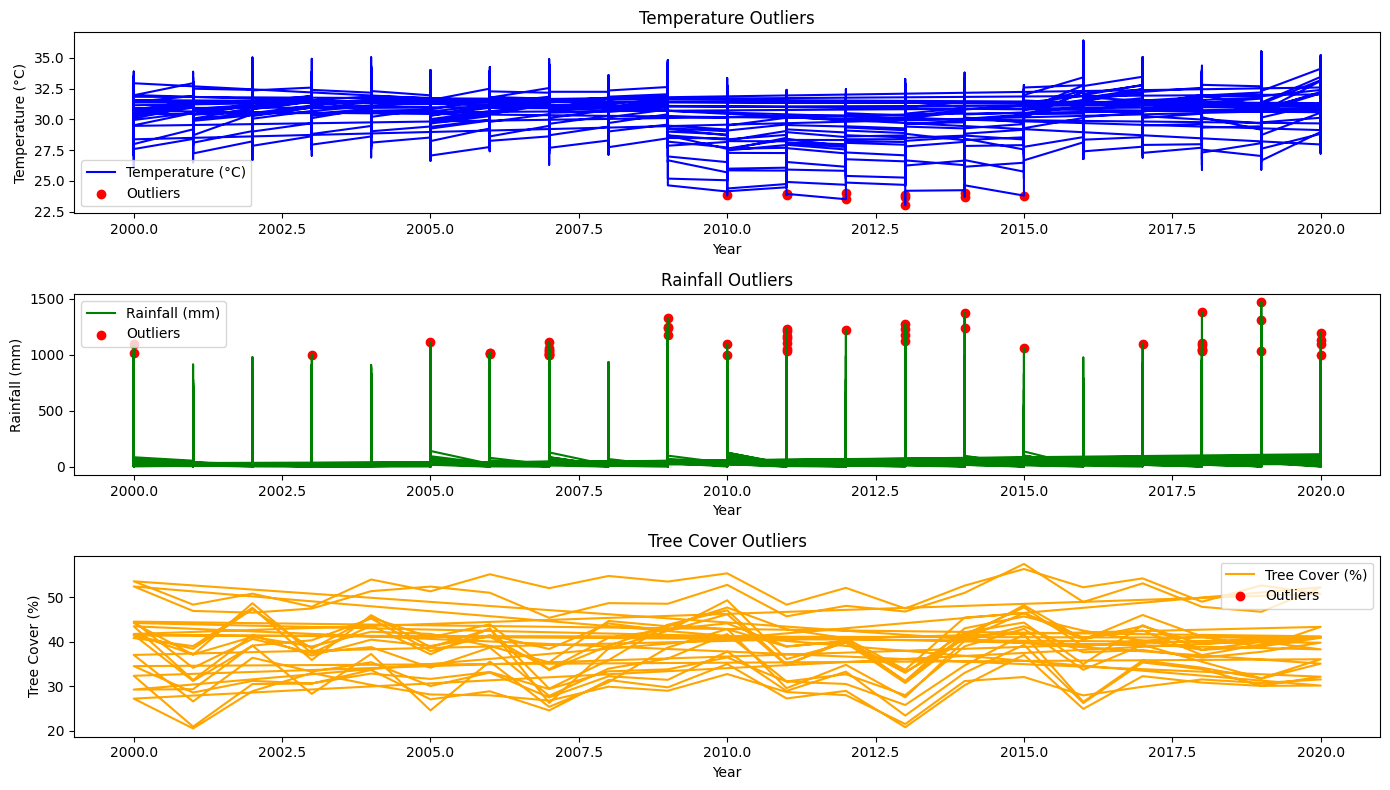

In [2]:
#plot checking for any outlier data and saving it in a csv file
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore

# Load the temperature, rainfall, and tree cover data from the CSV files
temperature_file_path = "/Users/prreddy/Projects/Kerala Data/Kerala_district_monthly_temperature_1981_2023.csv"
rainfall_file_path = "/Users/prreddy/Projects/Kerala Data/Kerala_district_monthly_rainfall_2000_2020.csv"
tree_cover_file_path = "/Users/prreddy/Projects/Kerala Data/Kerala_tree_cover_data.csv"
flooding_file_path = "/Users/prreddy/Projects/Kerala Data/kerala_district_monthly_flooding_2000_2023.csv"

temperature_df = pd.read_csv(temperature_file_path)
rainfall_df = pd.read_csv(rainfall_file_path)
tree_cover_df = pd.read_csv(tree_cover_file_path)
flooding_df = pd.read_csv(flooding_file_path)
# Function to detect outliers using Z-score
def detect_outliers_zscore(data, threshold=3):
    z_scores = zscore(data)
    abs_z_scores = np.abs(z_scores)
    outliers = np.where(abs_z_scores > threshold)
    return outliers

# Detect outliers in temperature data
temperature_outliers = detect_outliers_zscore(temperature_df['Temperature (°C)'])
temperature_outliers_df = temperature_df.iloc[temperature_outliers]

# Detect outliers in rainfall data
rainfall_outliers = detect_outliers_zscore(rainfall_df['Rainfall (mm)'])
rainfall_outliers_df = rainfall_df.iloc[rainfall_outliers]

# Detect outliers in tree cover data
tree_cover_outliers = detect_outliers_zscore(tree_cover_df['Tree Cover (%)'])
tree_cover_outliers_df = tree_cover_df.iloc[tree_cover_outliers]

flood_extent_outliers = detect_outliers_zscore(flooding_df['Flood Extent (sq km)'])
flood_extent_outliers_df = flooding_df.iloc[flood_extent_outliers]
# Save outliers to CSV files
# temperature_outliers_df.to_csv("kerala_temperature_outliers.csv", index=False)
# rainfall_outliers_df.to_csv("kerala_rainfall_outliers.csv", index=False)
# tree_cover_outliers_df.to_csv("kerala_tree_cover_outliers.csv", index=False)
# flood_extent_outliers_df.to_csv("kerala_flood_extent_outliers.csv", index=False)


# Print confirmation
print("Outliers detected and saved to CSV files.")

# Plotting the outliers
plt.figure(figsize=(14, 8))

# Plot temperature outliers
plt.subplot(3, 1, 1)
plt.plot(temperature_df['Year'], temperature_df['Temperature (°C)'], label='Temperature (°C)', color='blue')
plt.scatter(temperature_outliers_df['Year'], temperature_outliers_df['Temperature (°C)'], color='red', label='Outliers')
plt.title('Temperature Outliers')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.legend()

# Plot rainfall outliers
plt.subplot(3, 1, 2)
plt.plot(rainfall_df['Year'], rainfall_df['Rainfall (mm)'], label='Rainfall (mm)', color='green')
plt.scatter(rainfall_outliers_df['Year'], rainfall_outliers_df['Rainfall (mm)'], color='red', label='Outliers')
plt.title('Rainfall Outliers')
plt.xlabel('Year')
plt.ylabel('Rainfall (mm)')
plt.legend()

# Plot tree cover outliers
plt.subplot(3, 1, 3)
plt.plot(tree_cover_df['Year'], tree_cover_df['Tree Cover (%)'], label='Tree Cover (%)', color='orange')
plt.scatter(tree_cover_outliers_df['Year'], tree_cover_outliers_df['Tree Cover (%)'], color='red', label='Outliers')
plt.title('Tree Cover Outliers')
plt.xlabel('Year')
plt.ylabel('Tree Cover (%)')
plt.legend()

plt.tight_layout()
plt.show()





In [3]:
#Plots the annual tree cover , temperature, flooding and rainfall over the years for a state
import pandas as pd
import matplotlib.pyplot as plt
import os

def plot_climate_data(state_name, temperature_file, rainfall_file, tree_cover_file, flooding_file, output_dir):
    # Load the temperature, rainfall, tree cover, and flooding data from the CSV files
    temperature_df = pd.read_csv(temperature_file)
    rainfall_df = pd.read_csv(rainfall_file)
    tree_cover_df = pd.read_csv(tree_cover_file)
    flooding_df = pd.read_csv(flooding_file)

    # Filter data for the years 2000 to 2020
    temperature_df = temperature_df[(temperature_df['Year'] >= 2000) & (temperature_df['Year'] <= 2020)]
    rainfall_df = rainfall_df[(rainfall_df['Year'] >= 2000) & (rainfall_df['Year'] <= 2020)]
    tree_cover_df = tree_cover_df[(tree_cover_df['Year'] >= 2000) & (tree_cover_df['Year'] <= 2020)]
    flooding_df = flooding_df[(flooding_df['Year'] >= 2000) & (flooding_df['Year'] <= 2020)]

    # Calculate the annual mean temperature and total rainfall for each district
    annual_temperature = temperature_df.groupby(['Year', 'District'])['Temperature (°C)'].mean().reset_index()
    annual_rainfall = rainfall_df.groupby(['Year', 'District'])['Rainfall (mm)'].sum().reset_index()
    annual_flooding = flooding_df.groupby(['Year', 'District'])[ 'Flood Extent (sq km)'].sum().reset_index()

    # Merge the dataframes on Year and District
    merged_df = pd.merge(annual_temperature, annual_rainfall, on=['Year', 'District'])
    merged_df = pd.merge(merged_df, tree_cover_df, on=['Year', 'District'])
    merged_df = pd.merge(merged_df, annual_flooding, on=['Year', 'District'])

    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Get the list of unique districts
    districts = merged_df['District'].unique()

    # Loop through each district and plot the data
    for district in districts:
        district_df = merged_df[merged_df['District'] == district]
        
        # Plotting
        plt.figure(figsize=(14, 12))
        
        # Plot temperature
        plt.subplot(4, 1, 1)
        plt.plot(district_df['Year'], district_df['Temperature (°C)'], marker='o', color='r', label='Temperature (°C)')
        plt.title(f'Annual Temperature in {district} (2000-2020)')
        plt.xlabel('Year')
        plt.ylabel('Temperature (°C)')
        plt.grid(True)
        plt.legend()
        
        # Plot rainfall
        plt.subplot(4, 1, 2)
        plt.plot(district_df['Year'], district_df['Rainfall (mm)'], marker='o', color='b', label='Rainfall (mm)')
        plt.title(f'Annual Rainfall in {district} (2000-2020)')
        plt.xlabel('Year')
        plt.ylabel('Rainfall (mm)')
        plt.grid(True)
        plt.legend()
        
        # Plot tree cover
        plt.subplot(4, 1, 3)
        plt.plot(district_df['Year'], district_df['Tree Cover (%)'], marker='o', color='g', label='Tree Cover (%)')
        plt.title(f'Annual Tree Cover in {district} (2000-2020)')
        plt.xlabel('Year')
        plt.ylabel('Tree Cover (%)')
        plt.grid(True)
        plt.legend()
        
        # Plot flooding
        plt.subplot(4, 1, 4)
        plt.plot(district_df['Year'], district_df['Flood Extent (sq km)'], marker='o', color='brown', label='Flood Extent (sq km)')
        plt.title(f'Annual Flooding in {district} (2000-2020)')
        plt.xlabel('Year')
        plt.ylabel('Flood Extent (sq km)')
        plt.grid(True)
        plt.legend()
        
        plt.tight_layout()
        
        # Save the plot to the output directory
        plt.savefig(os.path.join(output_dir, f'{district}_combined_trends.png'))
        plt.close()  # Close the figure to free up memory

        print(f"Plot saved for {district}")

    print("All plots saved.")

# Example usage
plot_climate_data(
    state_name="Assam",
    temperature_file="Assam Data/Assam_district_monthly_temperature_1981_2023.csv",
    rainfall_file="Assam Data/Assam_district_monthly_rainfall_1981_2023.csv",
    tree_cover_file="Assam Data/Assam_district_annual_tree_cover_2000_2020.csv",
    flooding_file="Assam Data/Assam_district_monthly_flooding_2000_2023.csv",
    output_dir="Assam_district_combined_plots"
)

Plot saved for Barpeta
Plot saved for Bongaigaon
Plot saved for Cachar
Plot saved for Darrang
Plot saved for Dhemaji
Plot saved for Dhuburi
Plot saved for Dibrugarh
Plot saved for Goalpara
Plot saved for Golaghat
Plot saved for Hailakandi
Plot saved for Jorhat
Plot saved for Kamrup
Plot saved for Karbi Anglong
Plot saved for Karimganj
Plot saved for Kokrajhar
Plot saved for Lakhimpur
Plot saved for Marigaon
Plot saved for Nagaon
Plot saved for Nalbari
Plot saved for North Cachar Hills
Plot saved for Sibsagar
Plot saved for Sonitpur
Plot saved for Tinsukia
All plots saved.


In [23]:
#Plots the annual tree cover , temperature and rainfall over the years for a state
import pandas as pd
import matplotlib.pyplot as plt
import os

def plot_climate_data(state_name, temperature_file, rainfall_file, tree_cover_file, output_dir):
    # Load the temperature, rainfall, and tree cover data from the CSV files
    temperature_df = pd.read_csv(temperature_file)
    rainfall_df = pd.read_csv(rainfall_file)
    tree_cover_df = pd.read_csv(tree_cover_file)

    # Filter data for the years 2000 to 2020
    temperature_df = temperature_df[(temperature_df['Year'] >= 2000) & (temperature_df['Year'] <= 2020)]
    rainfall_df = rainfall_df[(rainfall_df['Year'] >= 2000) & (rainfall_df['Year'] <= 2020)]
    tree_cover_df = tree_cover_df[(tree_cover_df['Year'] >= 2000) & (tree_cover_df['Year'] <= 2020)]

    # Calculate the annual mean temperature and total rainfall for each district
    annual_temperature = temperature_df.groupby(['Year', 'District'])['Temperature (°C)'].mean().reset_index()
    annual_rainfall = rainfall_df.groupby(['Year', 'District'])['Rainfall (mm)'].sum().reset_index()

    # Merge the dataframes on Year and District
    merged_df = pd.merge(annual_temperature, annual_rainfall, on=['Year', 'District'])
    merged_df = pd.merge(merged_df, tree_cover_df, on=['Year', 'District'])

    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Get the list of unique districts
    districts = merged_df['District'].unique()

    # Loop through each district and plot the data
    for district in districts:
        district_df = merged_df[merged_df['District'] == district]
        
        # Plotting
        plt.figure(figsize=(14, 8))
        
        # Plot temperature
        plt.subplot(3, 1, 1)
        plt.plot(district_df['Year'], district_df['Temperature (°C)'], marker='o', color='r', label='Temperature (°C)')
        plt.title(f'Annual Temperature in {district} (2000-2020)')
        plt.xlabel('Year')
        plt.ylabel('Temperature (°C)')
        plt.grid(True)
        plt.legend()
        
        # Plot rainfall
        plt.subplot(3, 1, 2)
        plt.plot(district_df['Year'], district_df['Rainfall (mm)'], marker='o', color='b', label='Rainfall (mm)')
        plt.title(f'Annual Rainfall in {district} (2000-2020)')
        plt.xlabel('Year')
        plt.ylabel('Rainfall (mm)')
        plt.grid(True)
        plt.legend()
        
        # Plot tree cover
        plt.subplot(3, 1, 3)
        plt.plot(district_df['Year'], district_df['Tree Cover (%)'], marker='o', color='g', label='Tree Cover (%)')
        plt.title(f'Annual Tree Cover in {district} (2000-2020)')
        plt.xlabel('Year')
        plt.ylabel('Tree Cover (%)')
        plt.grid(True)
        plt.legend()
        
        plt.tight_layout()
        
        # Save the plot to the output directory
        plt.savefig(os.path.join(output_dir, f'{district}_combined_trends.png'))
        plt.close()  # Close the figure to free up memory

        print(f"Plot saved for {district}")

    print("All plots saved.")

# Example usage
plot_climate_data(
    state_name="Madhya Pradesh",
    temperature_file="/Users/prreddy/Projects/Madhya Pradesh Data/Madhya Pradesh_district_monthly_temperature_1981_2023.csv",
    rainfall_file="/Users/prreddy/Projects/Madhya Pradesh Data/Madhya Pradesh_district_monthly_rainfall_1981_2023.csv",
    tree_cover_file="/Users/prreddy/Projects/Madhya Pradesh Data/Madhya Pradesh_district_annual_tree_cover_2000_2020.csv",
    output_dir="Madhya Pradesh_district_combined_plots"
)

Plot saved for Anuppur
Plot saved for Ashoknagar
Plot saved for Balaghat
Plot saved for Barwani
Plot saved for Betul
Plot saved for Bhind
Plot saved for Bhopal
Plot saved for Burhanpur
Plot saved for Chhatarpur
Plot saved for Chhindwara
Plot saved for Damoh
Plot saved for Datia
Plot saved for Dewas
Plot saved for Dhar
Plot saved for Dindori
Plot saved for East Nimar
Plot saved for Guna
Plot saved for Gwalior
Plot saved for Harda
Plot saved for Hoshangabad
Plot saved for Indore
Plot saved for Jabalpur
Plot saved for Jhabua
Plot saved for Katni
Plot saved for Mandla
Plot saved for Mandsaur
Plot saved for Morena
Plot saved for Narsinghpur
Plot saved for Neemuch
Plot saved for Panna
Plot saved for Raisen
Plot saved for Rajgarh
Plot saved for Ratlam
Plot saved for Rewa
Plot saved for Sagar
Plot saved for Satna
Plot saved for Sehore
Plot saved for Seoni
Plot saved for Shahdol
Plot saved for Shajapur
Plot saved for Sheopur
Plot saved for Shivpuri
Plot saved for Sidhi
Plot saved for Tikamgarh


/Users/prreddy/Projects/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Temperature data saved as india_monthly_temperature_1981_2023.csv


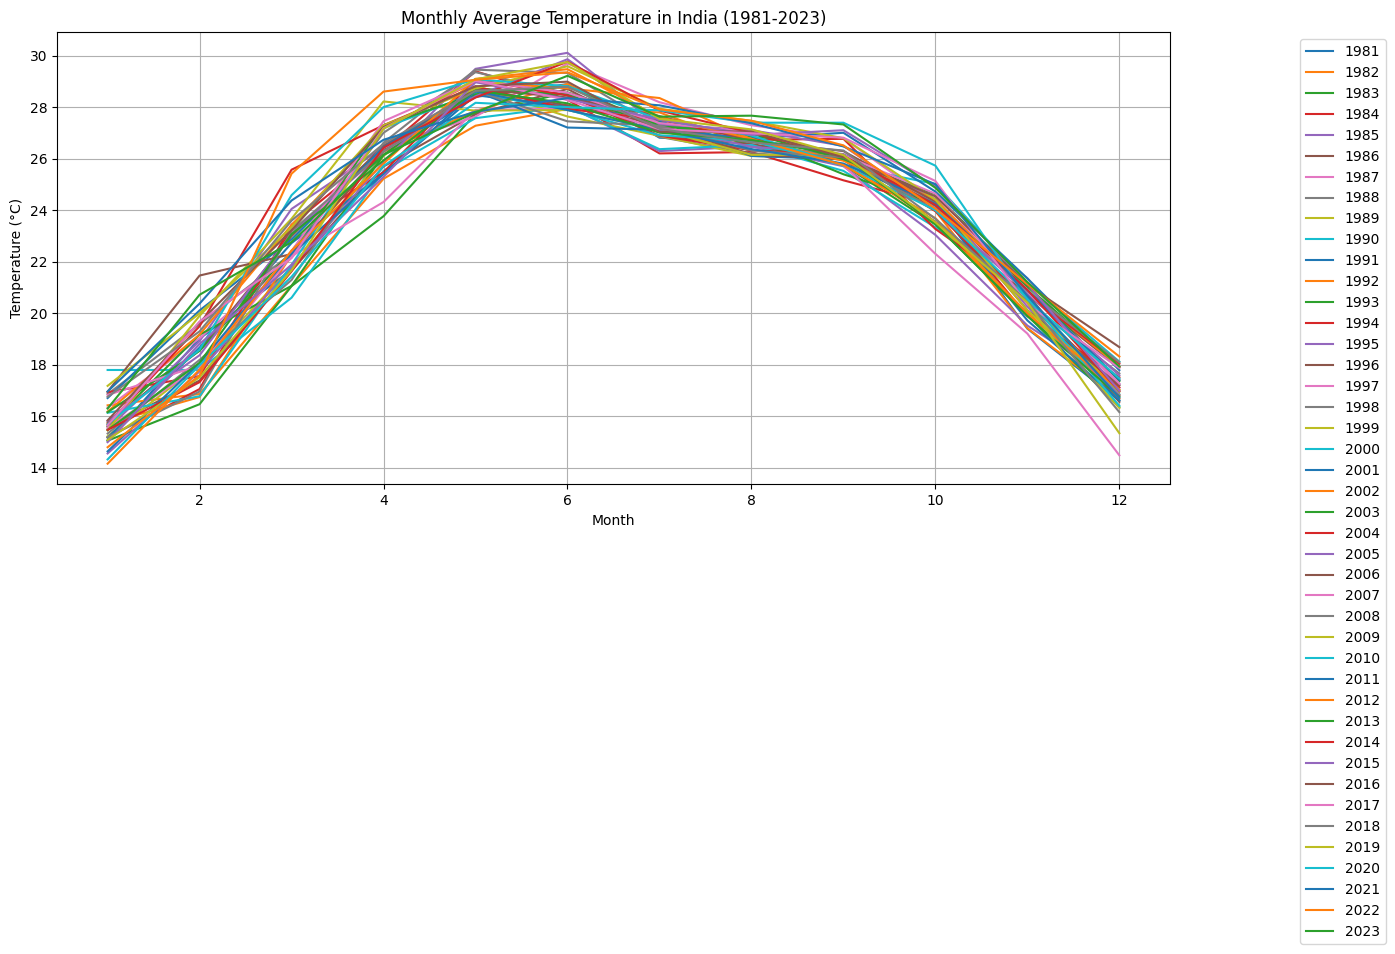

In [11]:
#Monthly average temperature in India from 1981 to 2023
import ee
import pandas as pd
import matplotlib.pyplot as plt

# Initialize the Earth Engine API
ee.Initialize()

# Define the geometry for India
india_geometry = ee.Geometry.Polygon([
    [68.1767, 7.9655], [68.1767, 35.5087], [97.4026, 35.5087], [97.4026, 7.9655], [68.1767, 7.9655]
])

# Load NOAA/CPC Temperature dataset
temperature_dataset = ee.ImageCollection("NOAA/CPC/Temperature") \
    .filterBounds(india_geometry) \
    .filterDate('1981-01-01', '2023-12-31') \
    .select("tmax")  # Maximum temperature

# Function to compute monthly average temperature for a given year and month
def get_monthly_temperature(year, month):
    start_date = ee.Date.fromYMD(year, month, 1)
    end_date = start_date.advance(1, 'month')

    # Filter temperature data for the specific month
    monthly_temp_collection = temperature_dataset.filterDate(start_date, end_date)
    
    # Compute the mean temperature for the month
    monthly_temp = monthly_temp_collection.mean().clip(india_geometry)

    # Calculate the mean temperature for the region
    mean_temp = monthly_temp.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=india_geometry,
        scale=5000,
        maxPixels=1e9
    ).get('tmax')

    return {'Year': year, 'Month': month, 'Temperature (°C)': mean_temp.getInfo()}

# Generate data for each month from 1981 to 2023
years = list(range(1981, 2024))
months = list(range(1, 13))

# Create a list of tasks
tasks = []
for year in years:
    for month in months:
        tasks.append((year, month))

# Function to process a single task
def process_task(task):
    year, month = task
    return get_monthly_temperature(year, month)

# Process tasks
results = [process_task(task) for task in tasks]

# Convert results to DataFrame
df_temperature = pd.DataFrame(results)

# Save to CSV
df_temperature.to_csv("india_monthly_temperature_1981_2023.csv", index=False)

# Print confirmation
print("Temperature data saved as india_monthly_temperature_1981_2023.csv")

# Plotting the data
plt.figure(figsize=(14, 8))

# Plot temperature
for year in years:
    yearly_data = df_temperature[df_temperature['Year'] == year]
    plt.plot(yearly_data['Month'], yearly_data['Temperature (°C)'], label=str(year))

plt.title('Monthly Average Temperature in India (1981-2023)')
plt.xlabel('Month')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.tight_layout()
plt.show()

    Year  Rainfall (mm)
0   2000   16405.761366
1   2001   18603.125572
2   2002    9344.690226
3   2003   18590.801075
4   2004   18309.544611
5   2005   18146.878416
6   2006   19545.830782
7   2007   17474.164451
8   2008   19193.174310
9   2009   14502.967013
10  2010   24151.440680
11  2011   23686.755283
12  2012   22583.595071
13  2013   26413.947701
14  2014   18257.898655
15  2015   17043.169645
16  2016   26246.032920
17  2017   18671.978336
18  2018   22312.589710
19  2019   27296.561669
20  2020   22109.556116


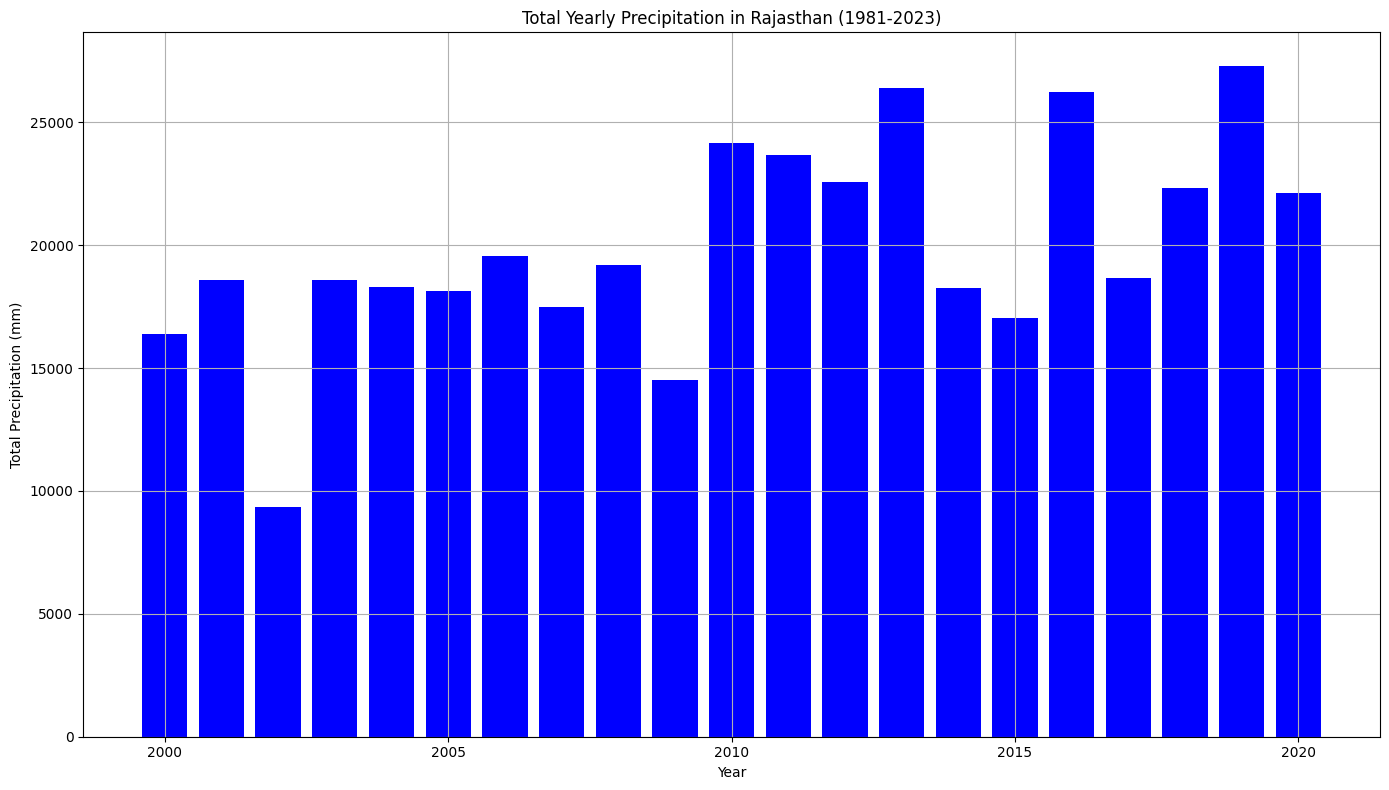

In [12]:
#plot displaying yearly precipitation in Rajasthan
import pandas as pd
import matplotlib.pyplot as plt

# Load the rainfall data from the CSV file
rainfall_file_path = "/Users/prreddy/Projects/Rajasthan Data/Rajasthan_district_monthly_rainfall_1981_2023.csv"
rainfall_df = pd.read_csv(rainfall_file_path)

# Calculate the total yearly precipitation for Rajasthan
yearly_precipitation = rainfall_df.groupby('Year')['Rainfall (mm)'].sum().reset_index()

# Print the total yearly precipitation
print(yearly_precipitation)

# Plotting the histogram
plt.figure(figsize=(14, 8))
plt.bar(yearly_precipitation['Year'], yearly_precipitation['Rainfall (mm)'], color='blue')
plt.title('Total Yearly Precipitation in Rajasthan (1981-2023)')
plt.xlabel('Year')
plt.ylabel('Total Precipitation (mm)')
plt.grid(True)
plt.tight_layout()
plt.show()

    Year  Temperature (°C)
0   1981         23.241761
1   1982         22.929594
2   1983         22.673411
3   1984         23.241824
4   1985         23.308266
5   1986         23.087225
6   1987         23.853093
7   1988         23.742505
8   1989         23.131272
9   1990         23.046345
10  1991         23.209505
11  1992         23.121006
12  1993         23.493425
13  1994         23.464323
14  1995         23.410760
15  1996         23.511691
16  1997         22.651660
17  1998         23.524868
18  1999         23.607303
19  2000         23.503514
20  2001         23.893002
21  2002         23.988451
22  2003         23.747796
23  2004         23.988471
24  2005         23.765979
25  2006         23.862473
26  2007         23.794472
27  2008         23.378870
28  2009         24.153853
29  2010         23.824406
30  2011         23.230425
31  2012         23.299091
32  2013         23.274256
33  2014         23.502428
34  2015         23.569313
35  2016         24.014803
3

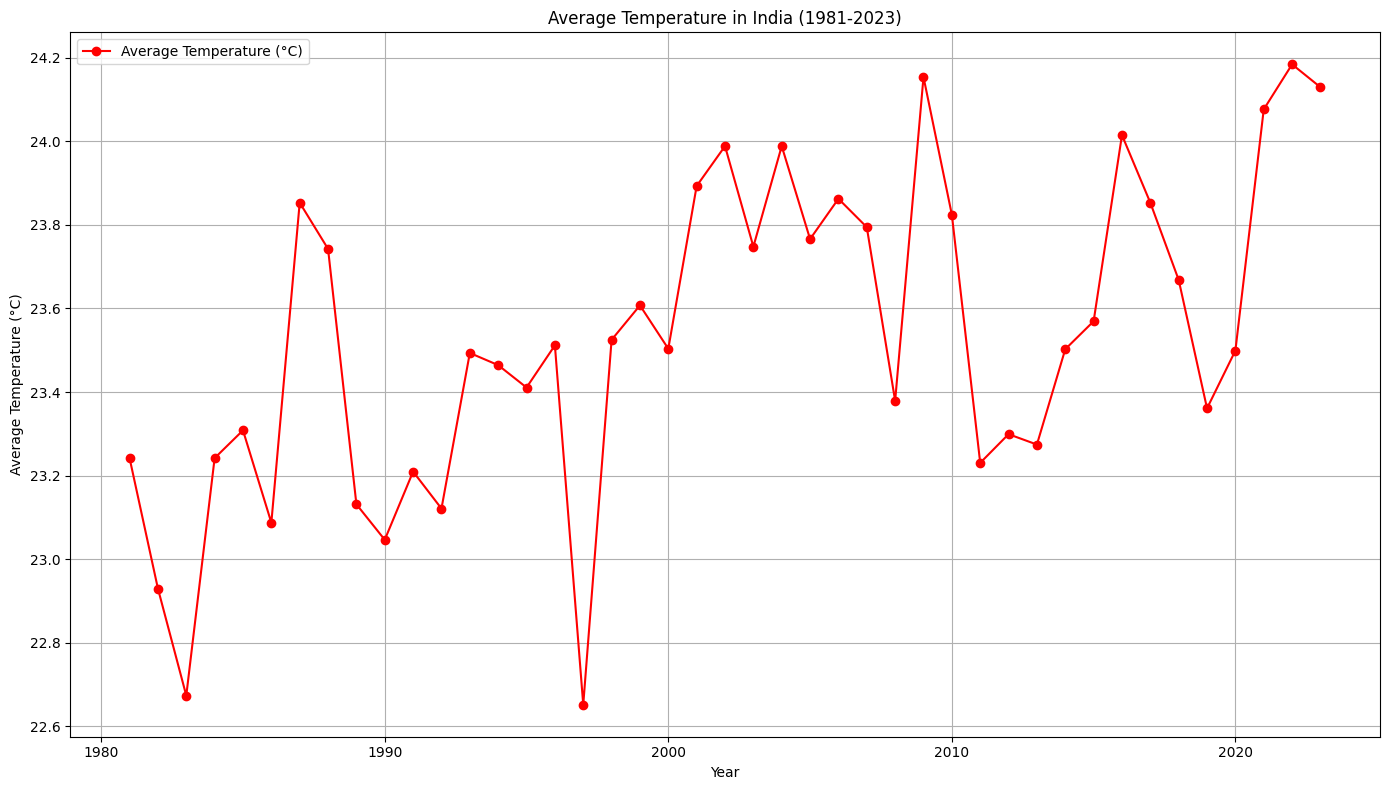

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the temperature data from the CSV file
temperature_file_path = "/Users/prreddy/Projects/india_monthly_temperature_1981_2023.csv"
temperature_df = pd.read_csv(temperature_file_path)

# Calculate the average temperature for each year
average_temperature_per_year = temperature_df.groupby('Year')['Temperature (°C)'].mean().reset_index()

# Print the average temperature per year
print(average_temperature_per_year)

# Plotting the average temperature over the years
plt.figure(figsize=(14, 8))
plt.plot(average_temperature_per_year['Year'], average_temperature_per_year['Temperature (°C)'], marker='o', color='r', label='Average Temperature (°C)')
plt.title('Average Temperature in India (1981-2023)')
plt.xlabel('Year')
plt.ylabel('Average Temperature (°C)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

<Figure size 1400x800 with 0 Axes>

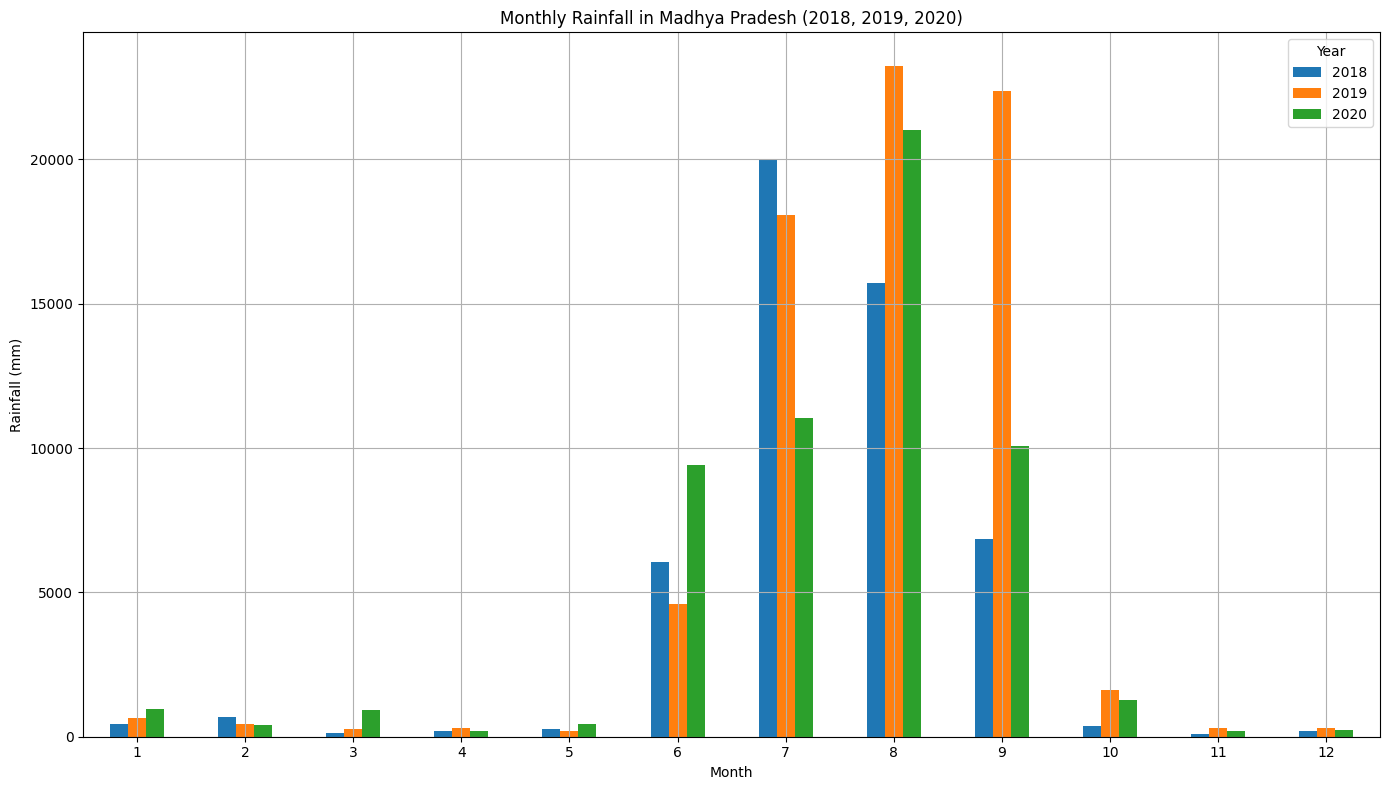

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the rainfall data from the CSV file
rainfall_file_path = "/Users/prreddy/Projects/Madhya Pradesh Data/Madhya Pradesh_district_monthly_rainfall_1981_2023.csv"
rainfall_df = pd.read_csv(rainfall_file_path)

# Filter data for Madhya Pradesh and the years 2018, 2019, and 2020
rainfall_df = rainfall_df[(rainfall_df['Year'].isin([2018, 2019, 2020]))]

# Group by Year and Month and calculate the total rainfall for each month
monthly_rainfall = rainfall_df.groupby(['Year', 'Month'])['Rainfall (mm)'].sum().reset_index()

# Pivot the data to have months as columns and years as rows
monthly_rainfall_pivot = monthly_rainfall.pivot(index='Month', columns='Year', values='Rainfall (mm)')

# Plotting the monthly rainfall
plt.figure(figsize=(14, 8))
monthly_rainfall_pivot.plot(kind='bar', figsize=(14, 8))

plt.title('Monthly Rainfall in Madhya Pradesh (2018, 2019, 2020)')
plt.xlabel('Month')
plt.ylabel('Rainfall (mm)')
plt.xticks(rotation=0)
plt.legend(title='Year')
plt.grid(True)
plt.tight_layout()
plt.show()

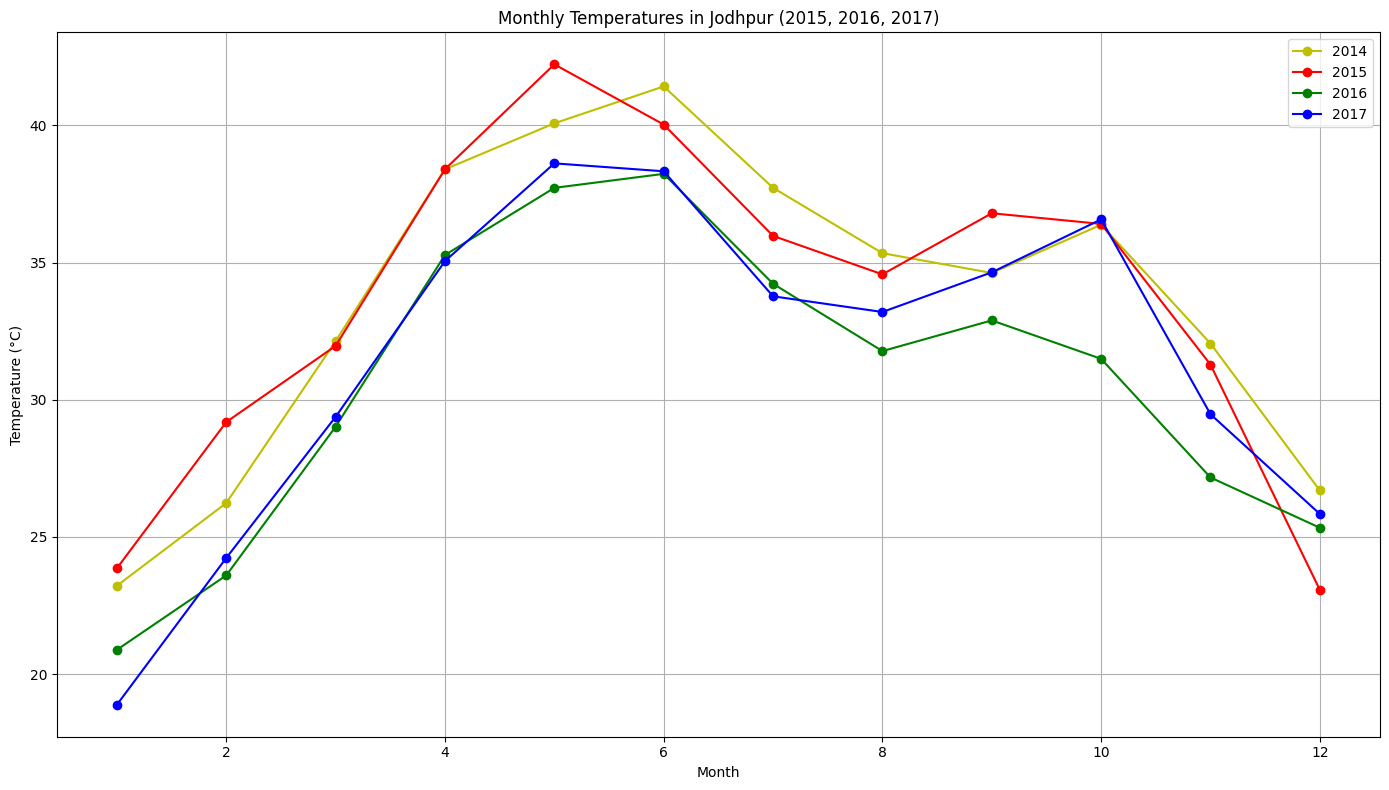

In [33]:
#Plot showing monthly temperatures in Jhodpur Rajasthan for the years 2014, 2015, 2016 and 2017
import pandas as pd
import matplotlib.pyplot as plt

# Load the temperature data from the CSV file
temperature_file_path = "/Users/prreddy/Projects/Rajasthan Data/Rajasthan_district_monthly_temperature_1981_2023.csv"
temperature_df = pd.read_csv(temperature_file_path)

# Filter data for Jodhpur and the years 2015, 2016, and 2017
jodhpur_temperature_df = temperature_df[(temperature_df['District'] == 'Jodhpur') & 
                                        (temperature_df['Year'].isin([2014,2015, 2016, 2017]))]

# Plotting the monthly temperatures for Jodhpur in 2015, 2016, and 2017
plt.figure(figsize=(14, 8))

temperature_2015 = jodhpur_temperature_df[jodhpur_temperature_df['Year'] == 2014]
plt.plot(temperature_2015['Month'], temperature_2015['Temperature (°C)'], marker='o', label='2014', color='y')

# Plot for 2015
temperature_2015 = jodhpur_temperature_df[jodhpur_temperature_df['Year'] == 2015]
plt.plot(temperature_2015['Month'], temperature_2015['Temperature (°C)'], marker='o', label='2015', color='r')

# Plot for 2016
temperature_2016 = jodhpur_temperature_df[jodhpur_temperature_df['Year'] == 2016]
plt.plot(temperature_2016['Month'], temperature_2016['Temperature (°C)'], marker='o', label='2016', color='g')

# Plot for 2017
temperature_2017 = jodhpur_temperature_df[jodhpur_temperature_df['Year'] == 2017]
plt.plot(temperature_2017['Month'], temperature_2017['Temperature (°C)'], marker='o', label='2017', color='b')

plt.title('Monthly Temperatures in Jodhpur (2015, 2016, 2017)')
plt.xlabel('Month')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.legend()
plt.tight_layout()

# Save the plot to a file
plt.savefig("jodhpur_monthly_temperatures_2015_2017.png")

# Show the plot
plt.show()

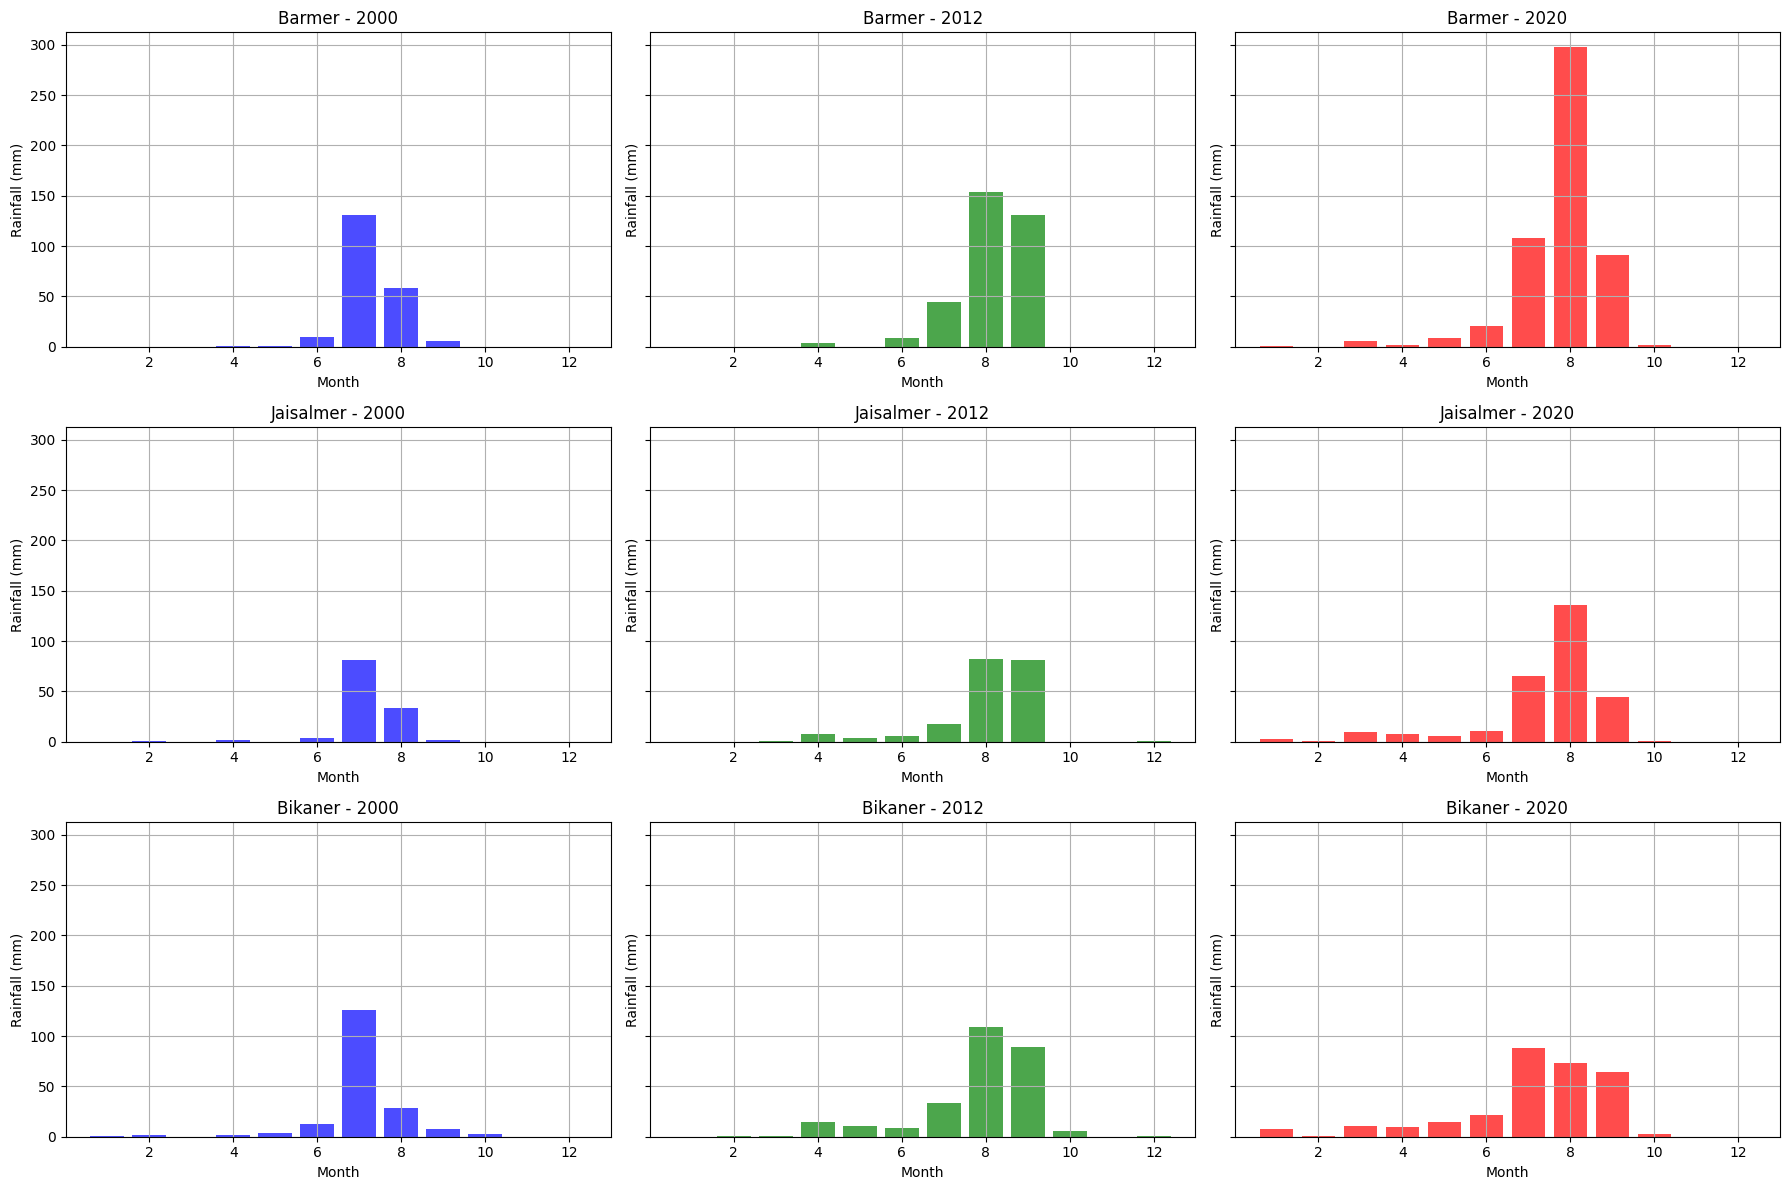

In [34]:
#plotting the monthly rainfall histograms of districts  Barmer ,Jaisalmer and Bikaner over 
# he decades 2000,2012 and 2020 to show shift in rainfall patterns
import pandas as pd
import matplotlib.pyplot as plt

# Load the rainfall data from the CSV file
rainfall_file_path = "/Users/prreddy/Projects/Rajasthan Data/Rajasthan_district_monthly_rainfall_1981_2023.csv"
rainfall_df = pd.read_csv(rainfall_file_path)

# Filter data for Barmer, Jaisalmer, and Bikaner and the years 2000, 2012, and 2020
districts = ['Barmer', 'Jaisalmer', 'Bikaner']
years = [2000, 2012, 2020]
filtered_rainfall_df = rainfall_df[(rainfall_df['District'].isin(districts)) & (rainfall_df['Year'].isin(years))]

# Plotting the monthly rainfall histograms side by side
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 12), sharey=True)

# Define colors for the plots
colors = ['b', 'g', 'r']

# Loop through each district and year to create the histograms
for i, district in enumerate(districts):
    for j, year in enumerate(years):
        monthly_rainfall = filtered_rainfall_df[(filtered_rainfall_df['District'] == district) & 
                                                (filtered_rainfall_df['Year'] == year)]
        axes[i, j].bar(monthly_rainfall['Month'], monthly_rainfall['Rainfall (mm)'], color=colors[j], alpha=0.7)
        axes[i, j].set_title(f'{district} - {year}')
        axes[i, j].set_xlabel('Month')
        axes[i, j].set_ylabel('Rainfall (mm)')
        axes[i, j].grid(True)

# Adjust layout
plt.tight_layout()

# Save the plot to a file
plt.savefig("monthly_rainfall_histograms_2000_2012_2020.png")

# Show the plot
plt.show()

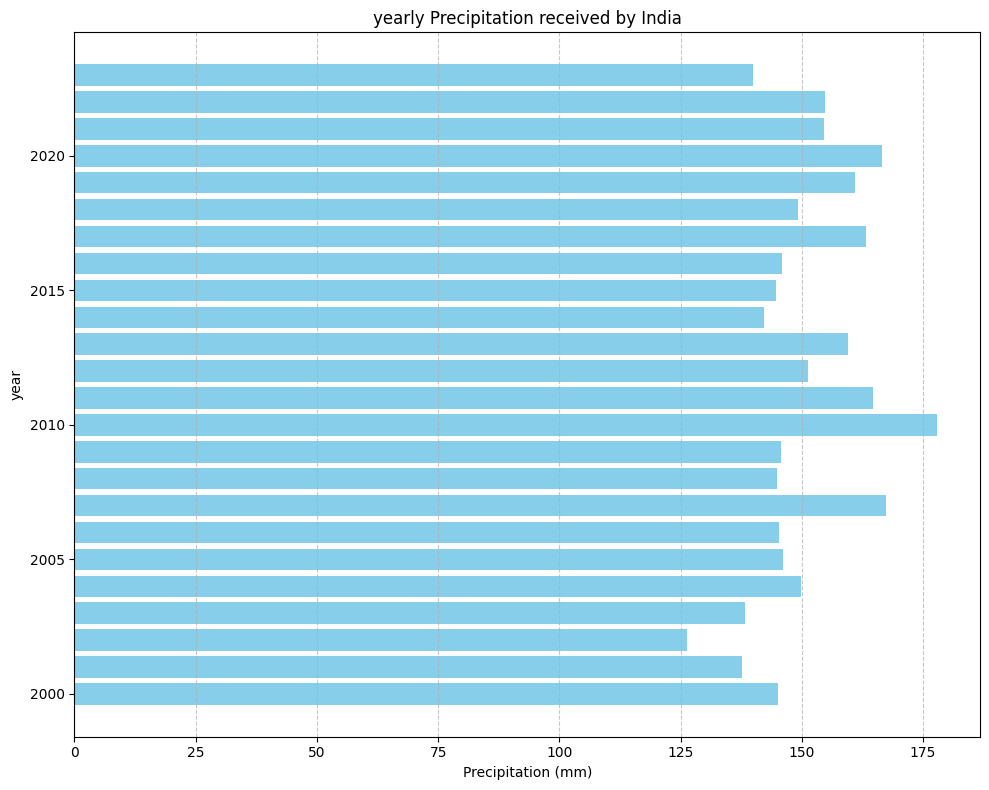

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
csv_file_path = 'India data/india_rainfall.csv'
data = pd.read_csv(csv_file_path)
yearly_precipitation = data.groupby('year')['rainfall'].sum().reset_index()

# Plot the horizontal bar graph
plt.figure(figsize=(10, 8))
plt.barh(yearly_precipitation['year'], yearly_precipitation['rainfall'], color='skyblue')
plt.xlabel('Precipitation (mm)')
plt.ylabel('year')
plt.title('yearly Precipitation received by India')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("yearly_rainfall_india_2000.png")
plt.show()


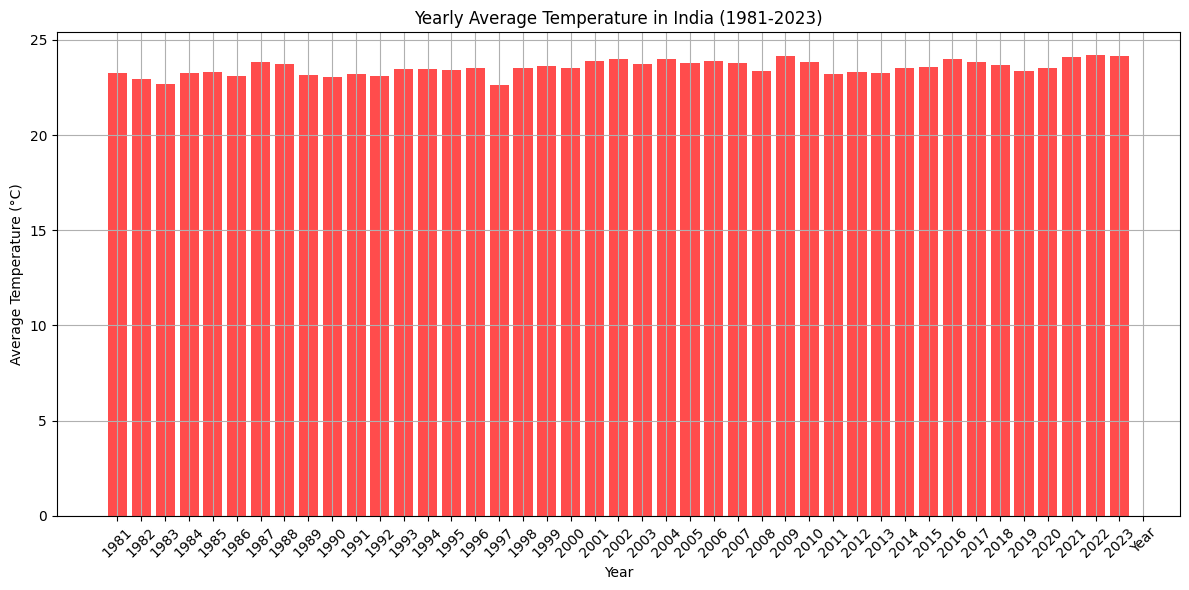

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure the 'Temperature' column is numeric
data['Temperature'] = pd.to_numeric(data['Temperature'], errors='coerce')

# Group by 'Year' and calculate the average 'Temperature' for each year
yearly_temperature = data.groupby('Year')['Temperature'].mean().reset_index()

# Plot the yearly average temperature as a bar graph
plt.figure(figsize=(12, 6))
plt.bar(yearly_temperature['Year'], yearly_temperature['Temperature'], color='red', alpha=0.7)
plt.xlabel('Year')
plt.ylabel('Average Temperature (°C)')
plt.title('Yearly Average Temperature in India (1981-2023)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("yearly_temperature_india_2000.png")
plt.show()


District       Chamoli     Naini Tal  Pauri Garhwal   Pithoragarh  \
Year                                                                
2000      32621.969495  31573.231832   56150.427039  38742.015215   
2001      28362.814045  26686.922644   37122.072911  30430.667767   
2002      16951.639115  19867.041978   33902.095024  22357.591888   
2003      26132.661974  25496.750827   37443.851414  28665.199175   
2004      39390.591236  37346.916826   50057.017998  38701.016308   
2005      34652.973702  37498.681412   49733.914031  34392.600413   
2006      25529.773006  33845.488496   39643.061912  28925.194998   
2007      36042.940920  36252.293262   51858.052676  35967.065721   
2008      30914.772646  31067.676116   50037.269951  39213.664934   
2009      57172.513991  50567.313812   71048.189820  55810.463739   
2010      51074.870707  45453.434082   61814.240922  52263.436458   
2011      43155.259073  44608.858189   58577.330326  49312.419198   
2012      39928.115224  37517.9804

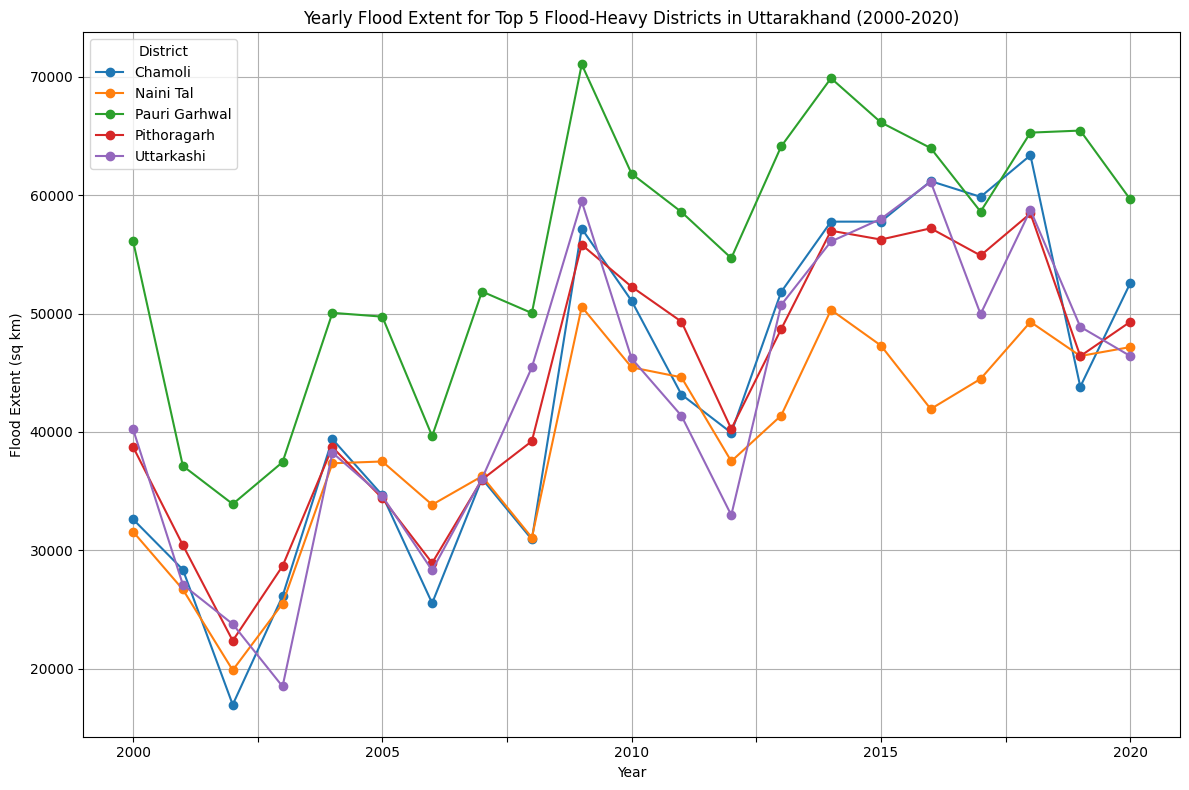

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
csv_file_path = 'Uttarakhand Data/Uttarakhand_district_monthly_flooding_2000_2023.csv'
data = pd.read_csv(csv_file_path, header=None, names=['Year', 'Month', 'District', 'Population', 'Flood_Extent'])

# Ensure the CSV file has columns 'Year', 'Month', 'District', 'Population', and 'Flood_Extent'
# Example CSV format:
# Year,Month,District,Population,Flood_Extent
# 2014,1,Bageshwar,2936613,2149.460502352942
# ...

# Convert 'Flood_Extent' to numeric, forcing errors to NaN
data['Flood_Extent'] = pd.to_numeric(data['Flood_Extent'], errors='coerce')

# Group by 'District' and sum the 'Flood_Extent' to find the most flood-heavy districts
district_flood_extent = data.groupby('District')['Flood_Extent'].sum().reset_index()

# Identify the 5 most flood-heavy districts
top_5_districts = district_flood_extent.nlargest(5, 'Flood_Extent')['District']

# Filter the data to include only the top 5 districts
top_5_data = data[data['District'].isin(top_5_districts)]

# Group by 'Year' and 'District' and sum the 'Flood_Extent' for each year
# Filter data to include only years till 2020
top_5_data = top_5_data[top_5_data['Year'].astype(int) <= 2020]

yearly_flood_extent = top_5_data.groupby(['Year', 'District'])['Flood_Extent'].sum().unstack()
print(yearly_flood_extent)
# Plot the graph
plt.figure(figsize=(12, 8))
yearly_flood_extent.plot(kind='line', marker='o', ax=plt.gca())
plt.xlabel('Year')
plt.ylabel('Flood Extent (sq km)')
plt.title('Yearly Flood Extent for Top 5 Flood-Heavy Districts in Uttarakhand (2000-2020)')
plt.legend(title='District')
plt.grid(True)
plt.tight_layout()
plt.savefig("top_5_flood_heavy_districts.png")
plt.show()